In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv

from scripts.merge import merge_cols
from scripts.convert import convert_to_holy_metric, find_unit

load_dotenv()
plt.style.use('Solarize_Light2')

sns.color_palette("colorblind")


# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


In [92]:
# Files

twenty_fifteen_bm = "data/2015-building-energy-benchmarking.csv"
twenty_sixteen_bm = "data/2016-building-energy-benchmarking.csv"


In [93]:
df_fifteen = pd.read_csv(twenty_fifteen_bm, dtype="unicode", low_memory=False)
df_sixteen = pd.read_csv(twenty_sixteen_bm, dtype="unicode", low_memory=False)


In [94]:
print("info : ", df_fifteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   OSEBuildingID                                                  3340 non-null   object
 1   DataYear                                                       3340 non-null   object
 2   BuildingType                                                   3340 non-null   object
 3   PrimaryPropertyType                                            3340 non-null   object
 4   PropertyName                                                   3340 non-null   object
 5   TaxParcelIdentificationNumber                                  3338 non-null   object
 6   Location                                                       3340 non-null   object
 7   CouncilDistrictCode                                            3340 n

In [95]:
print("info : ", df_sixteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   OSEBuildingID                    3376 non-null   object
 1   DataYear                         3376 non-null   object
 2   BuildingType                     3376 non-null   object
 3   PrimaryPropertyType              3376 non-null   object
 4   PropertyName                     3376 non-null   object
 5   Address                          3376 non-null   object
 6   City                             3376 non-null   object
 7   State                            3376 non-null   object
 8   ZipCode                          3360 non-null   object
 9   TaxParcelIdentificationNumber    3376 non-null   object
 10  CouncilDistrictCode              3376 non-null   object
 11  Neighborhood                     3376 non-null   object
 12  Latitude                         3

In [96]:
id_fifteen_list = list(df_fifteen["OSEBuildingID"])
id_sixteen_list = list(df_sixteen["OSEBuildingID"])

only_in_fifteen = [ident for ident in id_fifteen_list if ident not in id_sixteen_list]
only_in_sixteen = [ident for ident in id_sixteen_list if ident not in id_fifteen_list]

print(
    f"""{len(only_in_fifteen)} batiments ne sont présents que dans le benchmark 2015,\
 et {len(only_in_sixteen)} batiments ne sont présents que dans le benchmark 2016 """
  )


56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016 


In [97]:
col_onl_fifteen = [col for col in df_fifteen.columns if col not in df_sixteen.columns]

col_onl_sixteen = [col for col in df_sixteen.columns if col not in df_fifteen.columns]

print("Nombre de variables non communes aux deux datasets : ", len(col_onl_fifteen) + len(col_onl_sixteen))


Nombre de variables non communes aux deux datasets :  19


In [98]:
print(col_onl_sixteen)


['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [99]:
print(col_onl_fifteen)


['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']


## Premier constat : 

- 1 : Les dataset n'affichent des valeurs manquantes pour des variables secondaires (i.e. : SecondLargestPropertyUseType)
- 2 : Certaines propriétés ne sont présentes que dans un des deux dataset : elles devront être ignorés si l'on utilise une analyse d'évolution dans le temps
- 3 : Certaines variables ne sont pas presentes dans les deux datasets. (Ou changement de denomination : Address -> Location ?, Typos : Zip Code vs Zipcode)
- 4 : Les variables : city et state peuvent être supprimées : toutes les propriétés se trouvent à Seattle, dans l'Etat de Washington. Inutile d'alourdir les datasets.
- 5 : 56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016. Ils seront ignorés.

<hr> 

## Allegement et conversions :

- 1 : Plusieurs variables sont inutiles au datasets en general (Droplist)
- 2 : Certaines variables sont inutiles à l'étude et alourdissent inutilement le dataset mais peuvent être pertinentes pour décrire le batiment ou obtenir plus d'informations, elles sont écartées (df_meta)
- 3 : Le format d'adresse sur les données de 2015 est différent de celles de 2016 : compression des données de 2016 pour conformer au modèle du dataset 2015 (compress cols)
- 4 : Conversion des données au système métrique / international


In [100]:
rename_sixteen = {
    "Comments": "Comment",
    "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)",
    }

droplist = [
    "Zip Codes", "Zipcode", "SPD Beats", "2010 Census Tracts", "City Council Districts",
    "Seattle Police Department Micro Community Policing Plan Areas", "OtherFuelUse(kBtu)",  # OtherFuelUse not present in both datasets
    "SPD Beats", "CouncilDistrictCode", "Outlier", "DataYear", "ZipCode", "NaturalGas(therms)",  # Natural gas already present in another unit
    ]

# Columns not relevant to study but informative on the properties
meta_df_cols = [
    "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "Comment", "Location", "OSEBuildingID",
    "PrimaryPropertyType", "PropertyName", "YearBuilt"
    ]

meta_keep = ["OSEBuildingID", "PrimaryPropertyType", "PropertyName", "YearBuilt"]

compress_cols = ["Address", "City", "State", "Latitude", "Longitude"]


In [101]:
df_fifteen.drop(columns=droplist, errors="ignore", inplace=True)
df_sixteen.drop(columns=droplist, errors="ignore", inplace=True)


In [102]:
df_sixteen["Location"] = np.nan

merge_cols(origin_col_list=compress_cols, target_col_name="Location", dataframe=df_sixteen)

df_sixteen.drop(columns=compress_cols, inplace=True)


In [103]:
df_sixteen.rename(columns=rename_sixteen, inplace=True)

for col in df_sixteen.columns:
    if col not in df_fifteen.columns:
        raise BaseException("Mismatch")


In [104]:
meta_df_fifteen = df_fifteen[meta_df_cols]
meta_df_sixteen = df_sixteen[meta_df_cols]

meta_drop = [col for col in meta_df_cols if col not in meta_keep]

df_fifteen.drop(columns=meta_drop, inplace=True)
df_sixteen.drop(columns=meta_drop, inplace=True)


In [105]:
unit_stop_chars = ["(", ")", "GFA"]

manual_ignore = ["Electricity(kWh)", "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)"]

unit_cols = [col for col in df_fifteen.columns if (any(char in col for char in unit_stop_chars) and col not in manual_ignore)]


In [106]:
unit_dict = dict.fromkeys(unit_cols)

for col in unit_dict.keys(): 
    unit = find_unit(var_name=col, convert=True)["converted_unit"]

    if "GFA" in col:
        new_name = col.replace("GFA", "Area(SquareMetre)")
    elif ("("and ")") in col:
        start, end = col.find("("), col.find(")")
        before = col[:start + 1]
        after = col[end:]
        new_name = f"{before}{unit}{after}"
    
    df_fifteen[new_name] = np.nan
    df_sixteen[new_name] = np.nan
    unit_dict[col] = new_name

for key, value in unit_dict.items():

    for index, series in df_fifteen.iterrows():
        df_fifteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)
    for index, series in df_sixteen.iterrows():
        df_sixteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)

df_fifteen.drop(columns=unit_dict.keys(), inplace=True)
df_sixteen.drop(columns=unit_dict.keys(), inplace=True)


In [107]:
# Suppression des batiments non communs aux deux datasets via leur ID

df_fifteen = df_fifteen[~df_fifteen["OSEBuildingID"].isin(only_in_fifteen)]

df_sixteen = df_sixteen[~df_sixteen["OSEBuildingID"].isin(only_in_sixteen)]


## Analyse des données :
- 1.a : Représentation des batiments en fonction de leurs dates de construction.
- 1.b : Visualisation des statistiques principales de la variable : Energie par metre carré
- 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.
- 2.a : Repartition de la note Energy Star au sein des données.
- 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré.
- 3 : Paire 3 : Energy Star en fonction de l'année de construction.
- 4 : Représentation Property Type/Utilisation Energie

### Cette analyse permettra de :
 - Visualiser "l'age" du paysage de Seattle
 - Contextualiser la mesure de la consommation d'énergie au metre carré, et sa possible relation avec l'age des batiments
 - Avoir une meilleure comprehension de la variable Energy Star et de la présenter face à l'age des batiments et de leur consommation en energie

<hr>

# I : Analyse d'un seul dataset

# II : Reduction de dimension, normalisation et fusion des datasets

<hr>

# I : Analyse séparée
## 1 : L'age des batiments et leur consommation en energie
### 1.a : L'age du paysage de Seattle

In [108]:
# We can use df_16 since the data is more recent for energy use and didnt change for construction date

data_age = list(df_sixteen["YearBuilt"].astype(int))
oldest = min(data_age)
youngest = max(data_age)

print(f"Le plus ancien batiment date de {oldest}, le plus récent (en 2016) date de {youngest}")


Le plus ancien batiment date de 1900, le plus récent (en 2016) date de 2015


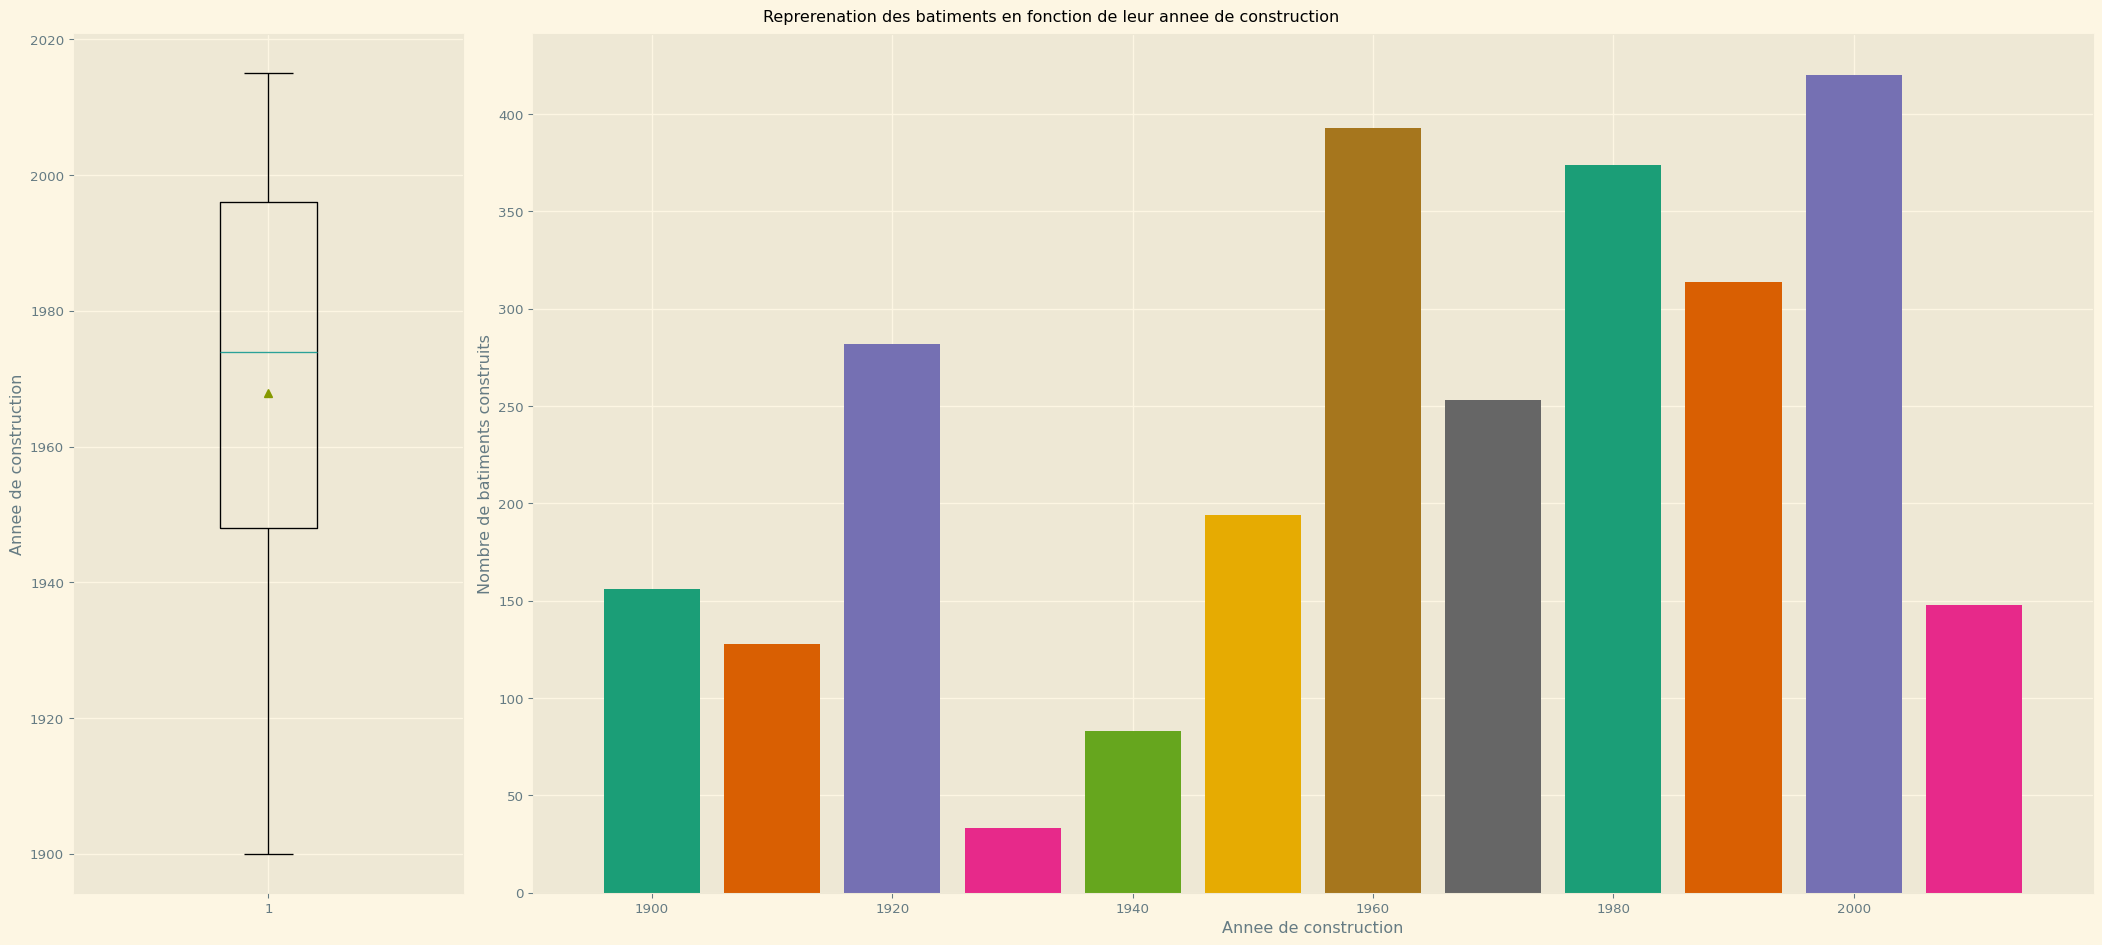

In [109]:
decades = np.arange(1900, 2020, 10)

building_per_decade = dict.fromkeys(decades)

for decade in building_per_decade.keys():
    built = len([year for year in data_age if (year > decade and year < decade + 10)])
    building_per_decade[decade] = built

used_cmap = plt.get_cmap("Dark2")

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 10),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi
    )

ax1.boxplot(data_age, showmeans=True, widths=0.25)

ax2.bar(building_per_decade.keys(), height=building_per_decade.values(), width=8, color=used_cmap.colors)
# ax2 lineplot

###
# Titles & Labels
ax1.set_ylabel("Annee de construction")
ax2.set_ylabel("Nombre de batiments construits")
ax2.set_xlabel("Annee de construction")
fig.suptitle("Reprerenation des batiments en fonction de leur annee de construction")
fig.tight_layout()
#
###

plt.show()


Comment Zone

## 1.b Visualisation des statistiques principales de la variable : Energie par metre carré

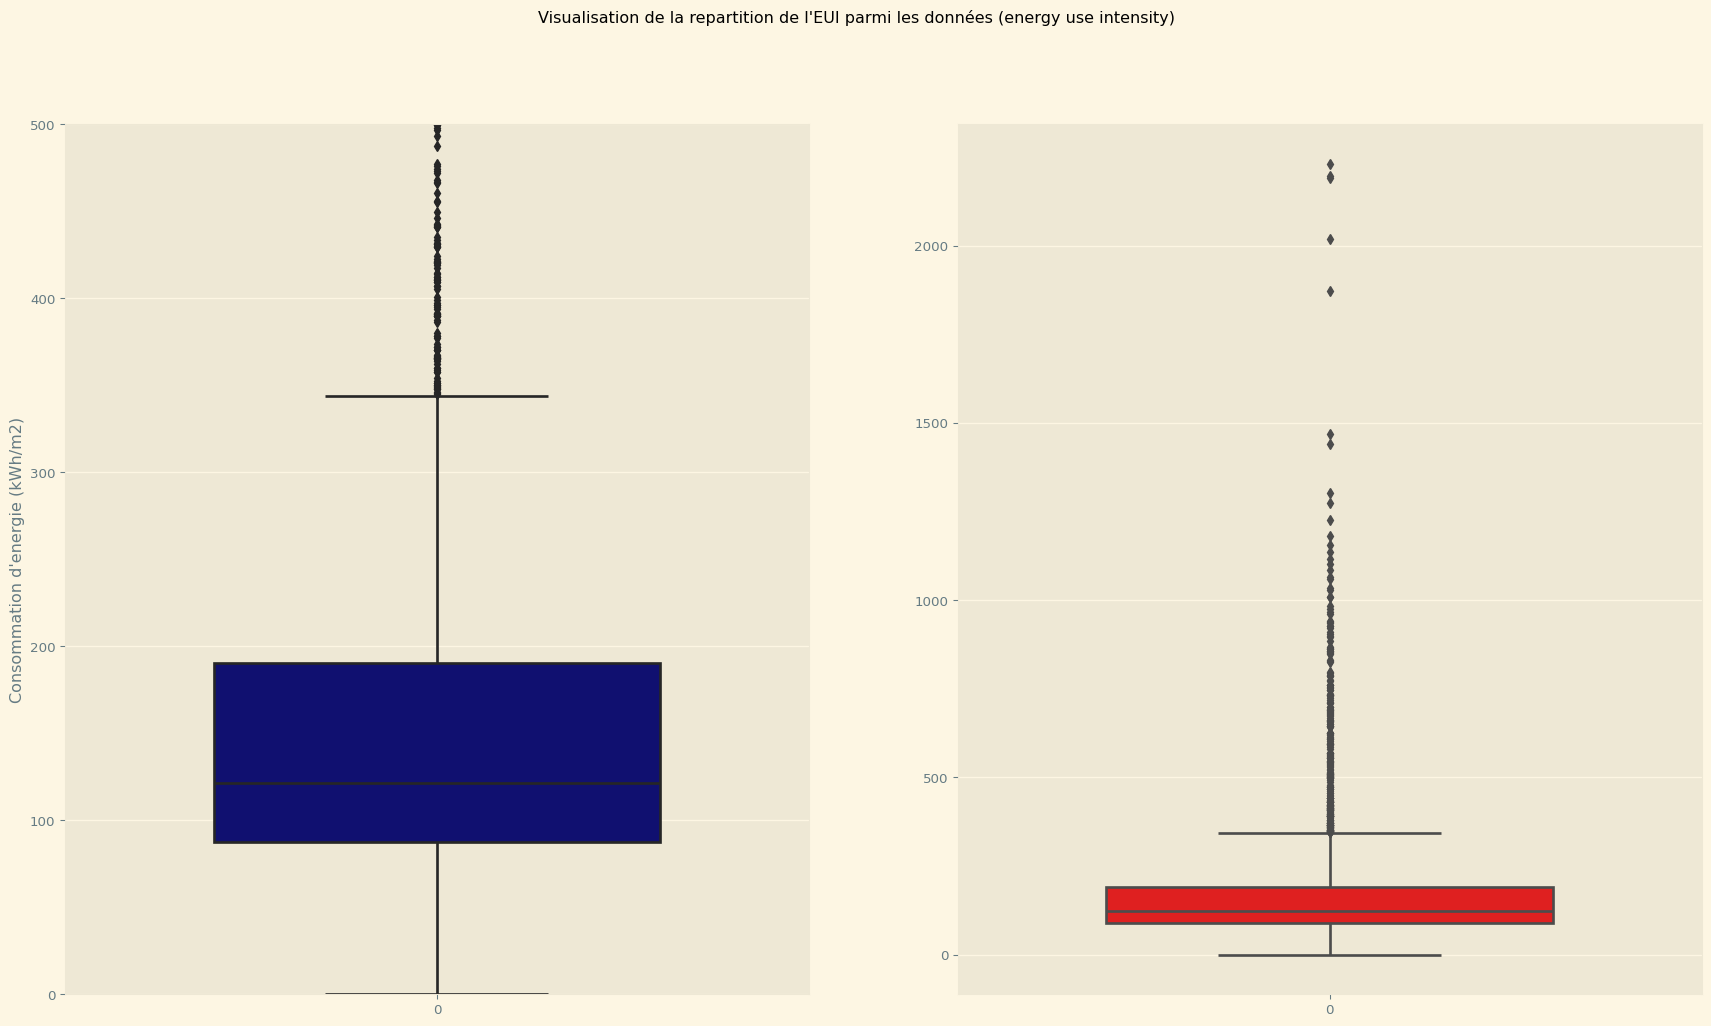

count    3278.000000
mean      170.962418
std       170.593548
min         0.000000
25%        87.697600
50%       121.451715
75%       190.142911
max      2231.241469
Name: SiteEUI(kWh/m2), dtype: float64


In [110]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
    )

site_eui_data = list(df_sixteen["SiteEUI(kWh/m2)"].values.astype(float))

sns.boxplot(data=site_eui_data, width=0.6, ax=ax1, color="navy")
ax1.set_ylim(0, 500)  # High number of outliers, cf describe
sns.boxplot(data=site_eui_data, width=0.6, ax=ax2, color="red")
# fig.tight_layout()

###
# Titles/Lables
ax1.set_ylabel("Consommation d'energie (kWh/m2)")
fig.suptitle("Visualisation de la repartition de l'EUI parmi les données (energy use intensity)")
#
###

plt.show()

print(df_sixteen["SiteEUI(kWh/m2)"].astype(float).describe())


### Analyse :

- 1 : Les outliers sont extrèmement nombreux, uniquement dans les utilisations "hautes"
- 2 : La majorité des batiments ont une EUI entre 87 et 190 kWh/m2, 170 en moyenne.
- 3 : L'élimination de batiments via la methode interquartile peut être viable, la reduction de dimension via ACP peut également être une piste

Corrections requises : typos et \n

## Possibilité de valider et ameliorer ce groupement via Kmeans

### 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.

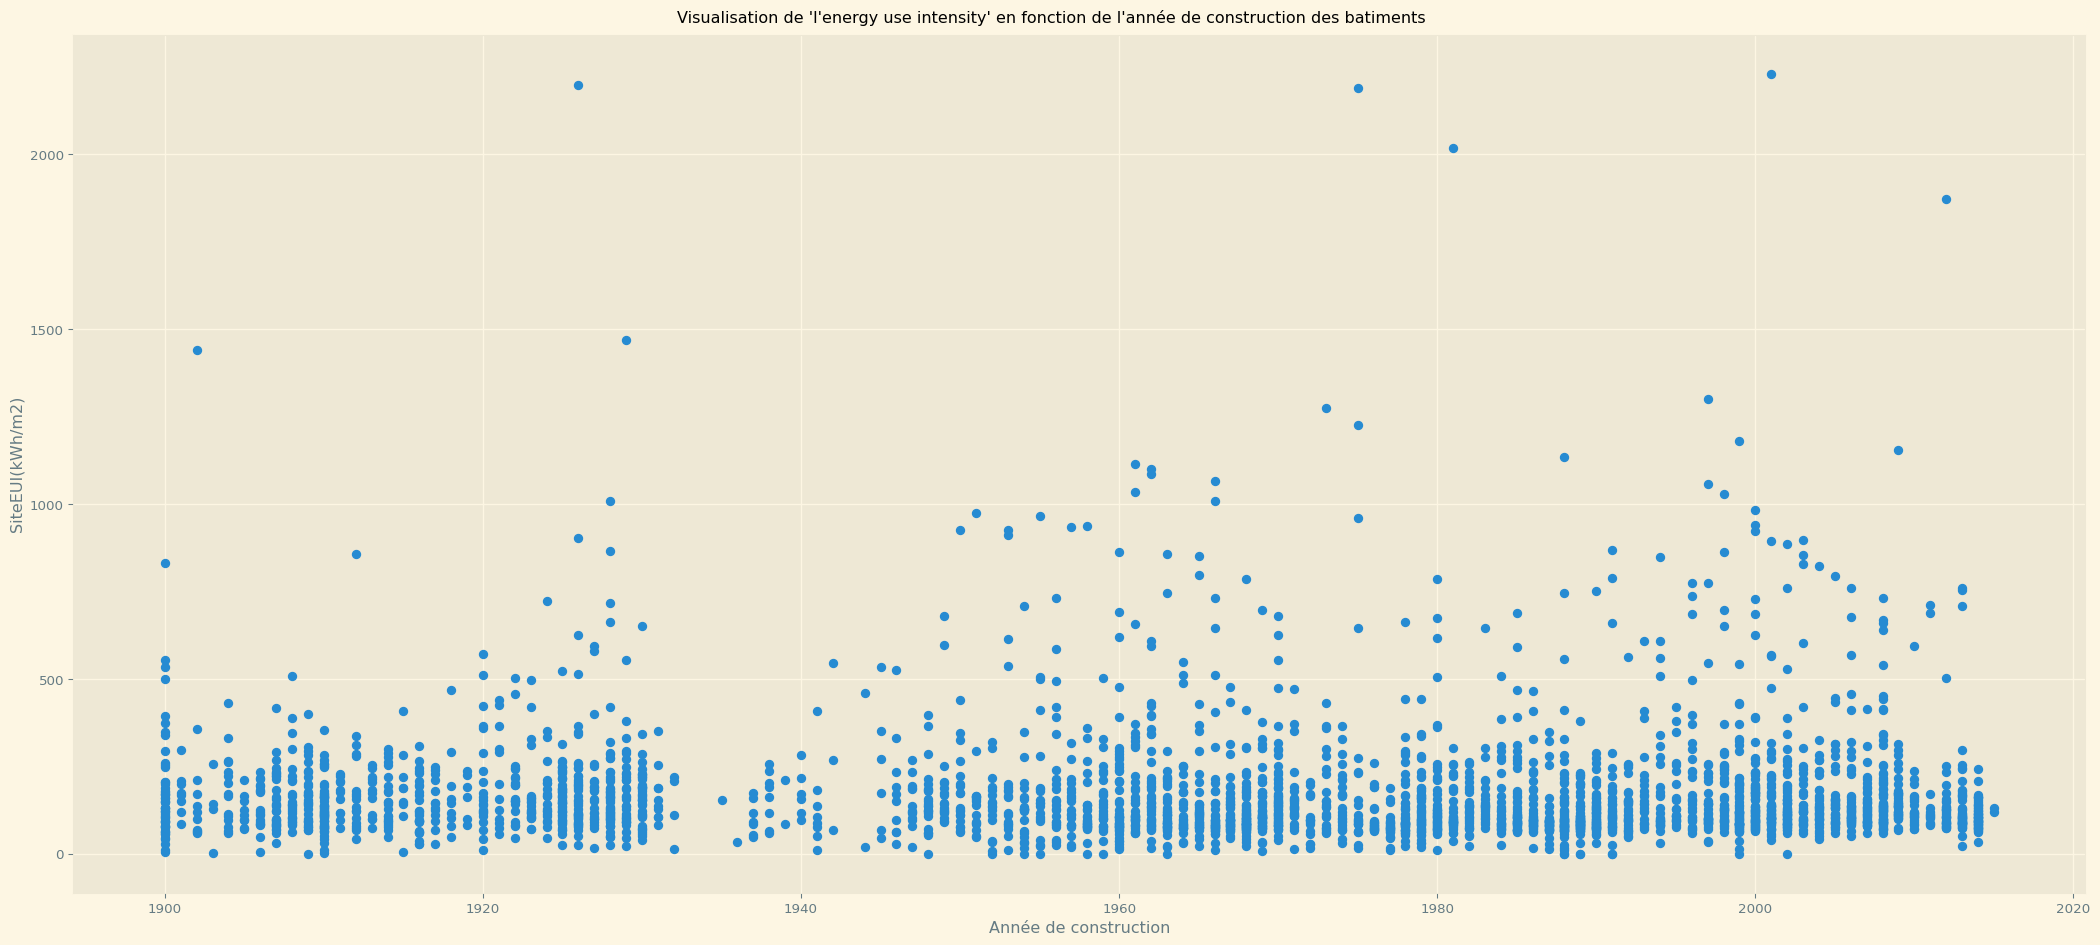

In [111]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1.scatter(
    x=df_sixteen["YearBuilt"].astype(int).values,
    y=df_sixteen["SiteEUI(kWh/m2)"].values.astype(float),
    )

###
# Titles/Lables
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Année de construction")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de l'année de construction des batiments")
#
###
fig.tight_layout()
plt.show()


### Observation : 
- L'age des batiments ne semble pas avoir d'impact sur leur intensité d'utilisation énergétique. On peut emettre l'hypothèse que les batiments les plus anciens ont été modernisés pour avoir une consommation energetique plus responsable.
- Que cette hypothèse soit vraie ou fausse, le graphique ci dessus ne semble pas montrer une corréllation claire entre l'age d'un batiment et l'intensité de son utilisation energetique.
- On peut verifier cela avec un diagramme en barres, qui serait plus pertinent pour visualiser ces chiffres.

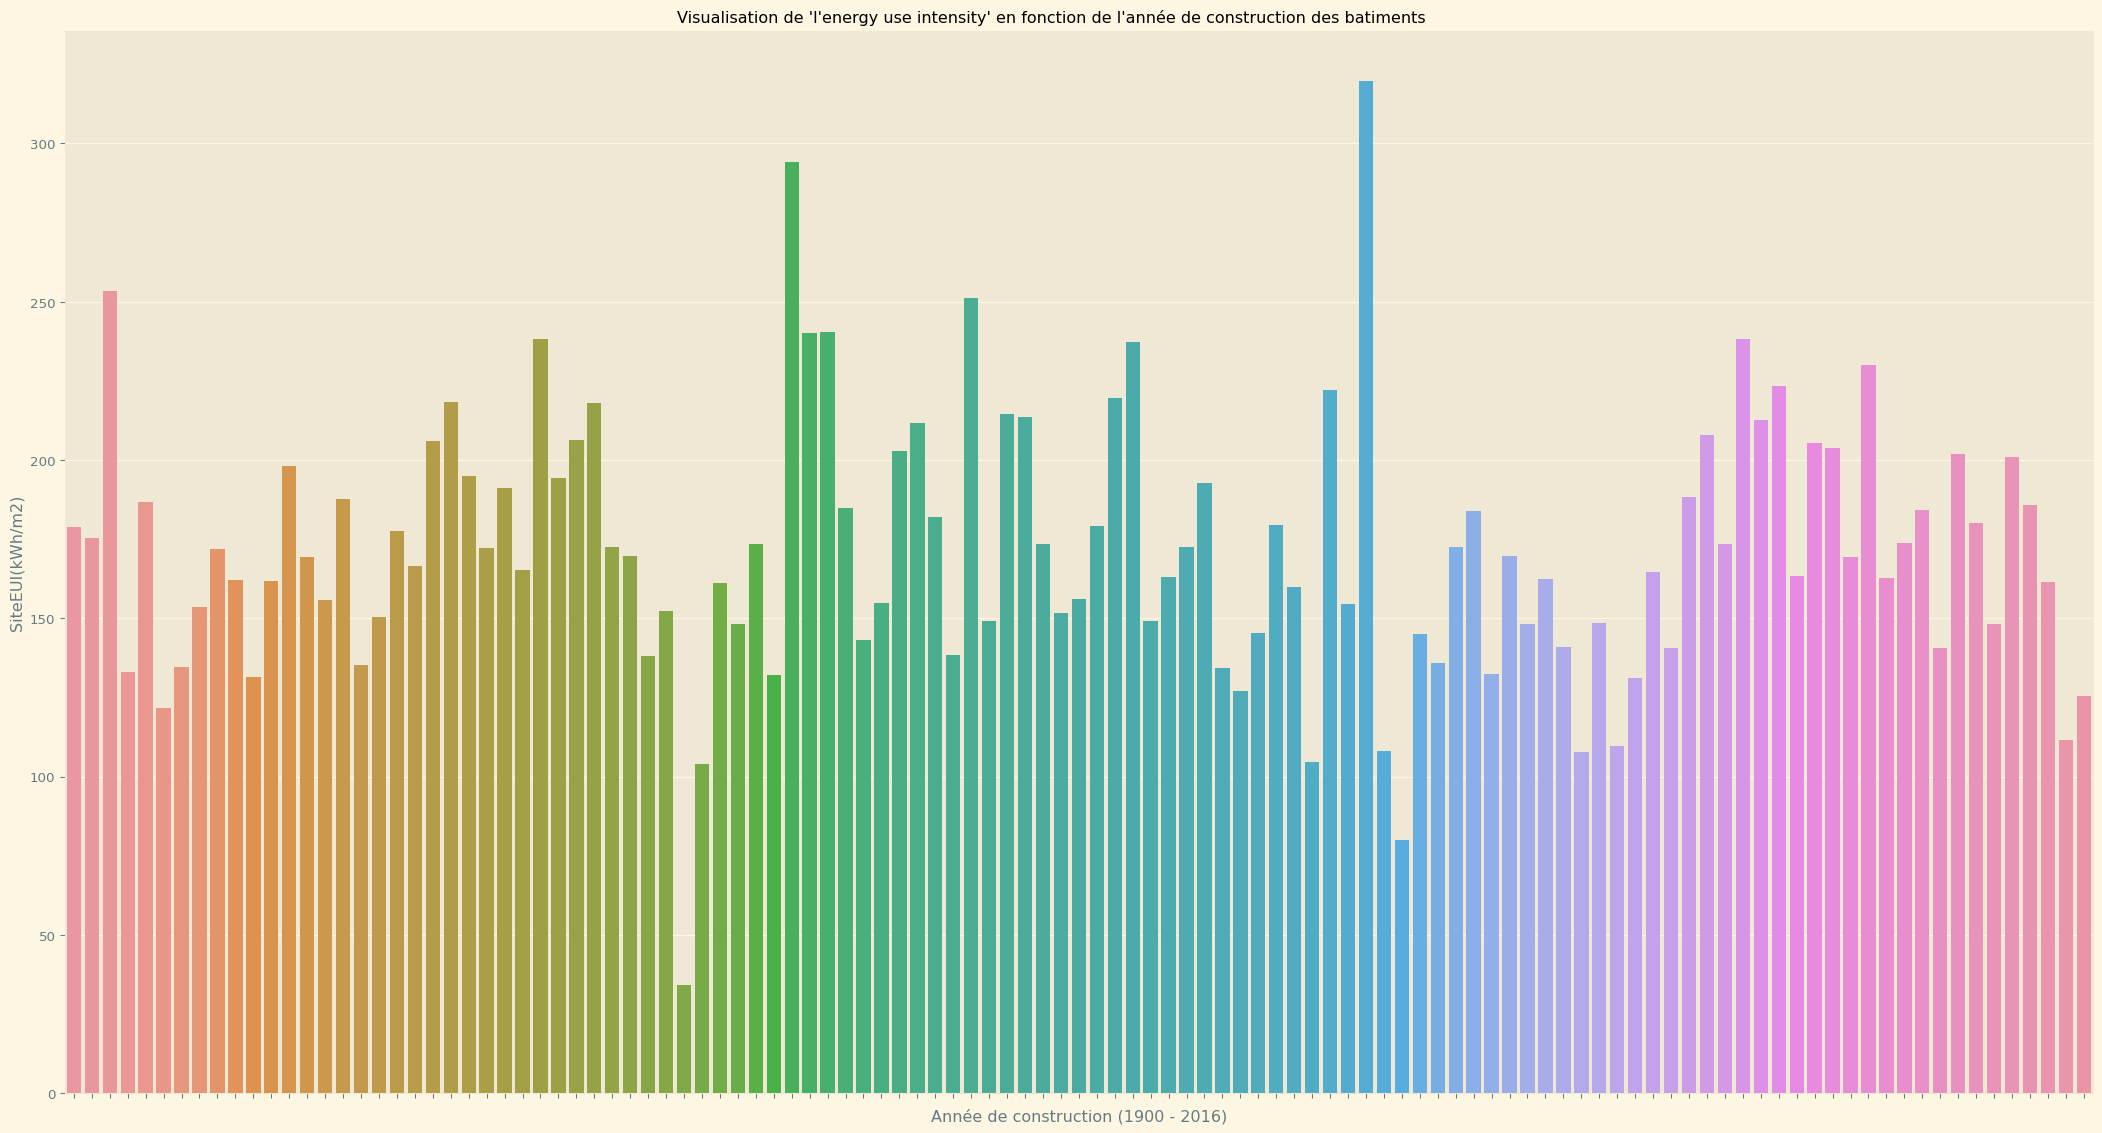

In [112]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_sixteen["YearBuilt"].astype(int).values,
    y=df_sixteen["SiteEUI(kWh/m2)"].values.astype(float),
    ci=None
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Année de construction (1900 - 2016)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de l'année de construction des batiments")

#
###
fig.tight_layout()
plt.show()


### L'utilisation d'un autre type de visualisation confirme qu'on ne peut pas, de facon fiable, corréler l'intensité de l'utilisation energetique avec l'age d'un batiment

## 2.a La variable Energy Star au sein des données

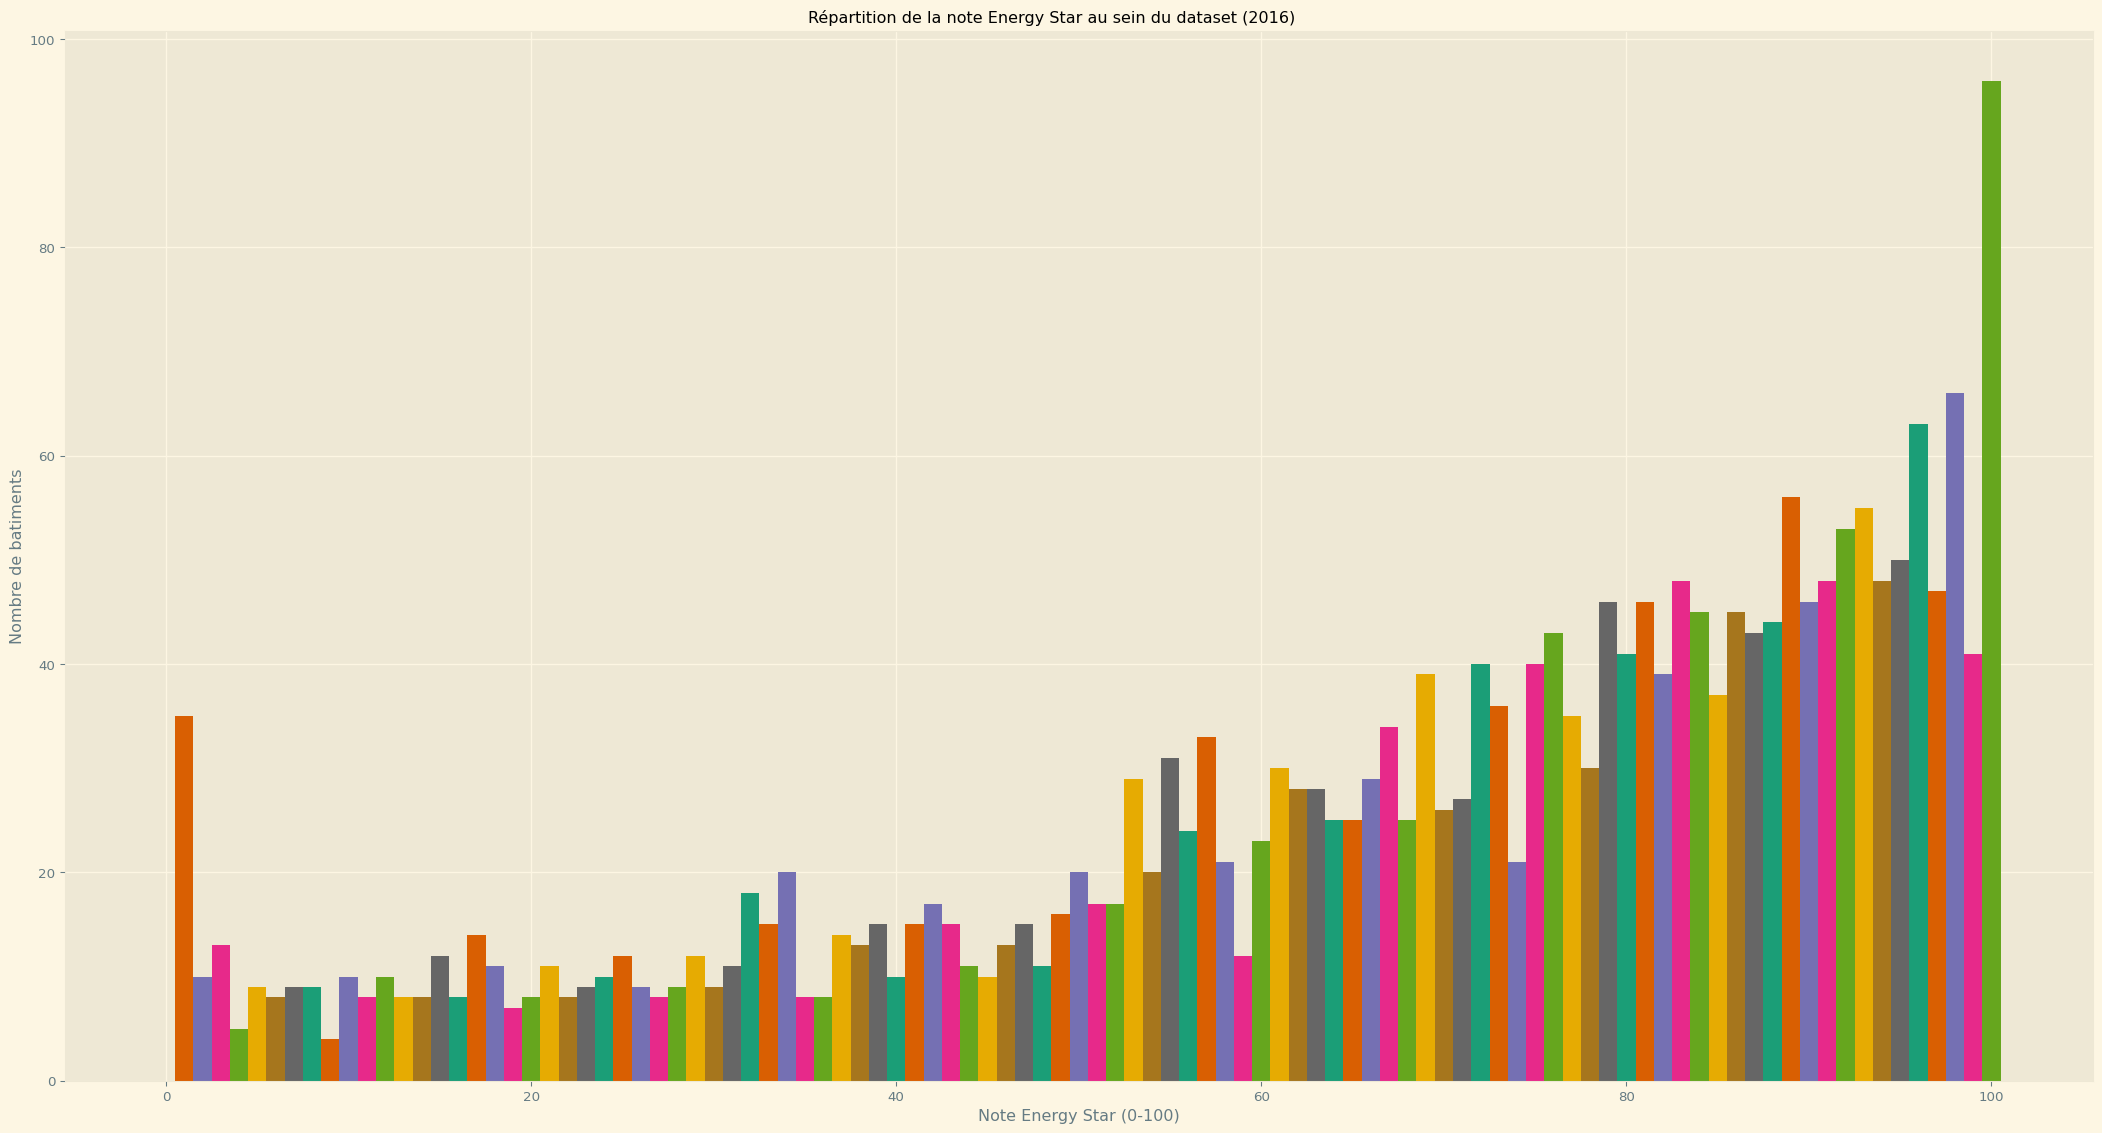

In [113]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

rated = df_sixteen[df_sixteen["ENERGYSTARScore"].notna()]
scores = list(rated["ENERGYSTARScore"].astype(int).values)
score_range = range(0, 101, 1)
scores_dict = dict.fromkeys(score_range)

for score in scores_dict.keys():
    scores_dict[score] = scores.count(score)

ax1.bar(
    x=list(scores_dict.keys()),
    height=list(scores_dict.values()),
    color=used_cmap.colors,
    width=1
    )

####
## Titles/Lables
ax1.set_ylabel("Nombre de batiments")
ax1.set_xlabel("Note Energy Star (0-100)")
fig.suptitle("Répartition de la note Energy Star au sein du dataset (2016)")
##
####

fig.tight_layout()

plt.show()


### Repartition des notes Energy Star au sein du jeu de données.

## 2.b : Paire 2 : Note Energy Star en fonction de l’énergie par mètre carré.

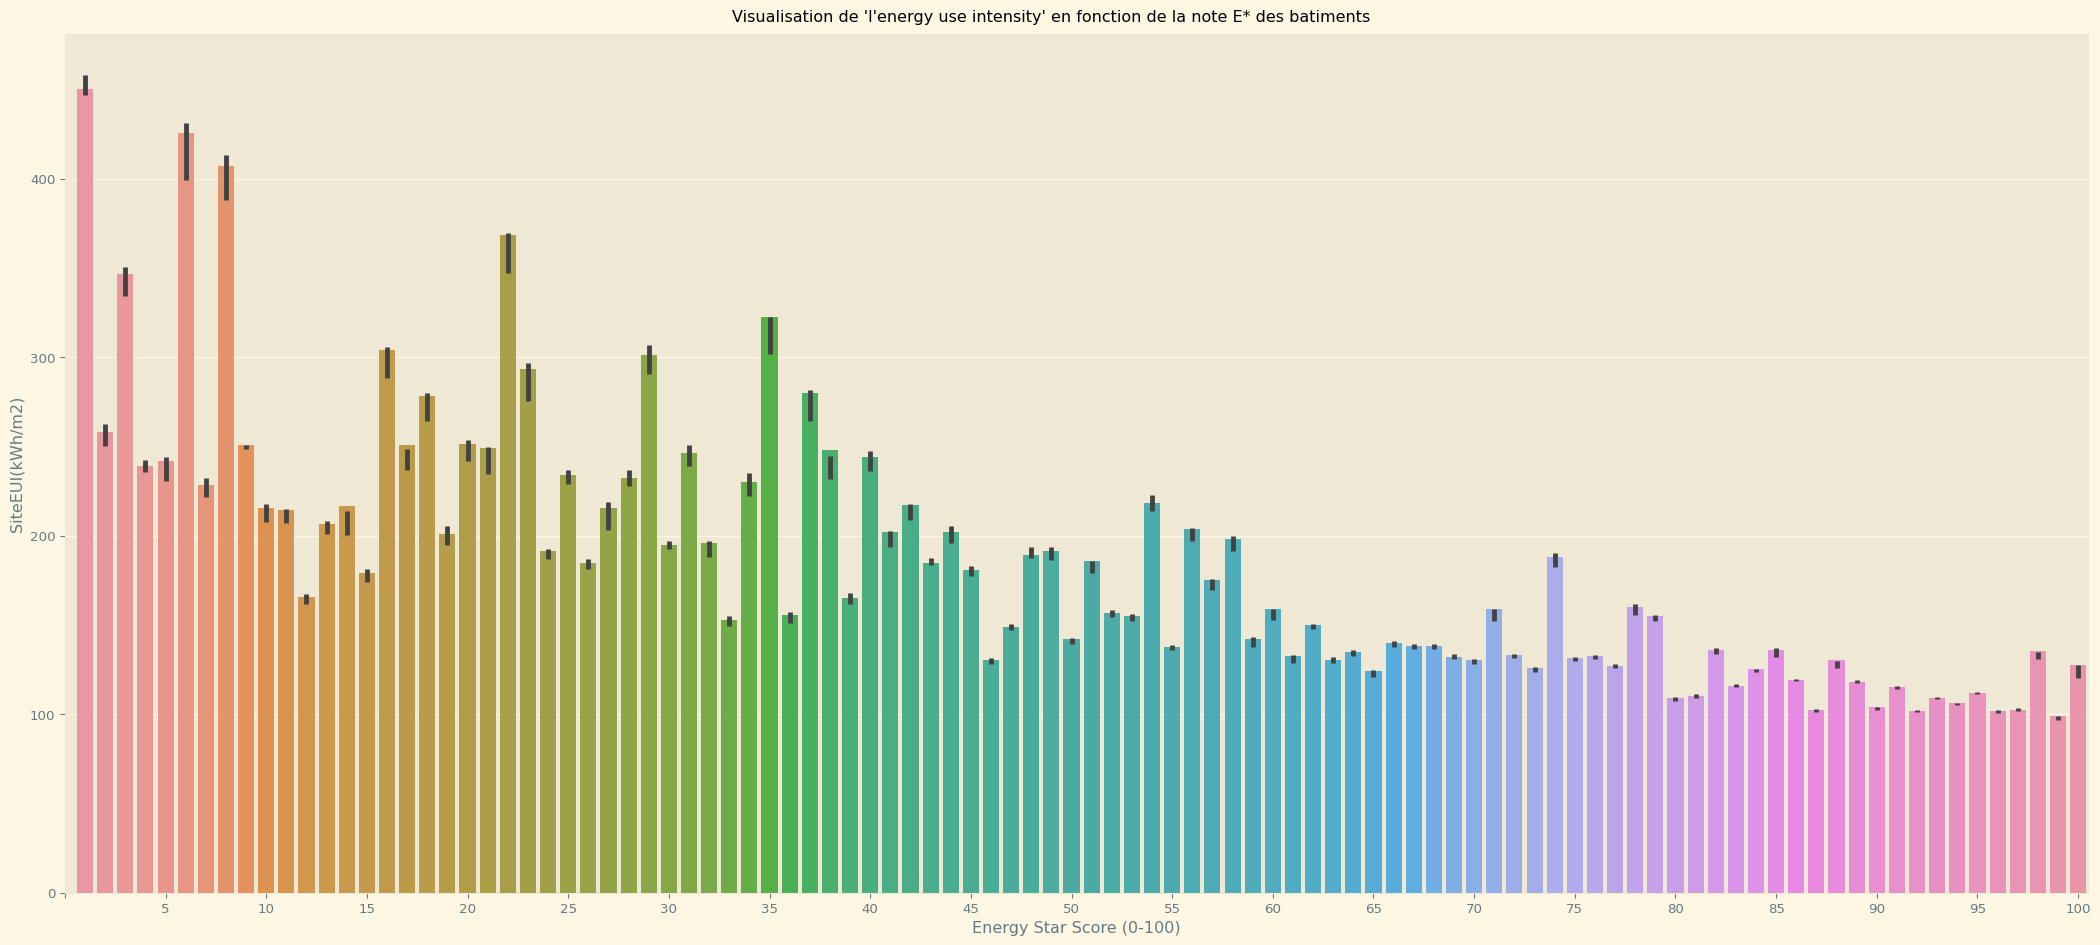

In [114]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["SiteEUI(kWh/m2)"].values.astype(float),
    ci=10
)


###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()

### Observation 
- On peut observer ici un lien clair entre le Score Energy Star (E*) et l'intensité d'utilisation énergétique (UIS). Le lien est logique dans ce cas : le site E* explique que, entre autres, l'utilisation d'énergie est un facteur.
- Le site internet d'E* fourni également une motivation pour l'obtention de cette note : un batiment est "Energy Star Certified" lorsque sa note est supérieure ou égale à 75 (ce qui peut expliquer le pic autour de cette note : les developpeurs immobiliers ont interèt à obtenir cette certification)

## Paire 3 : Rapport entre E* et année de construction :

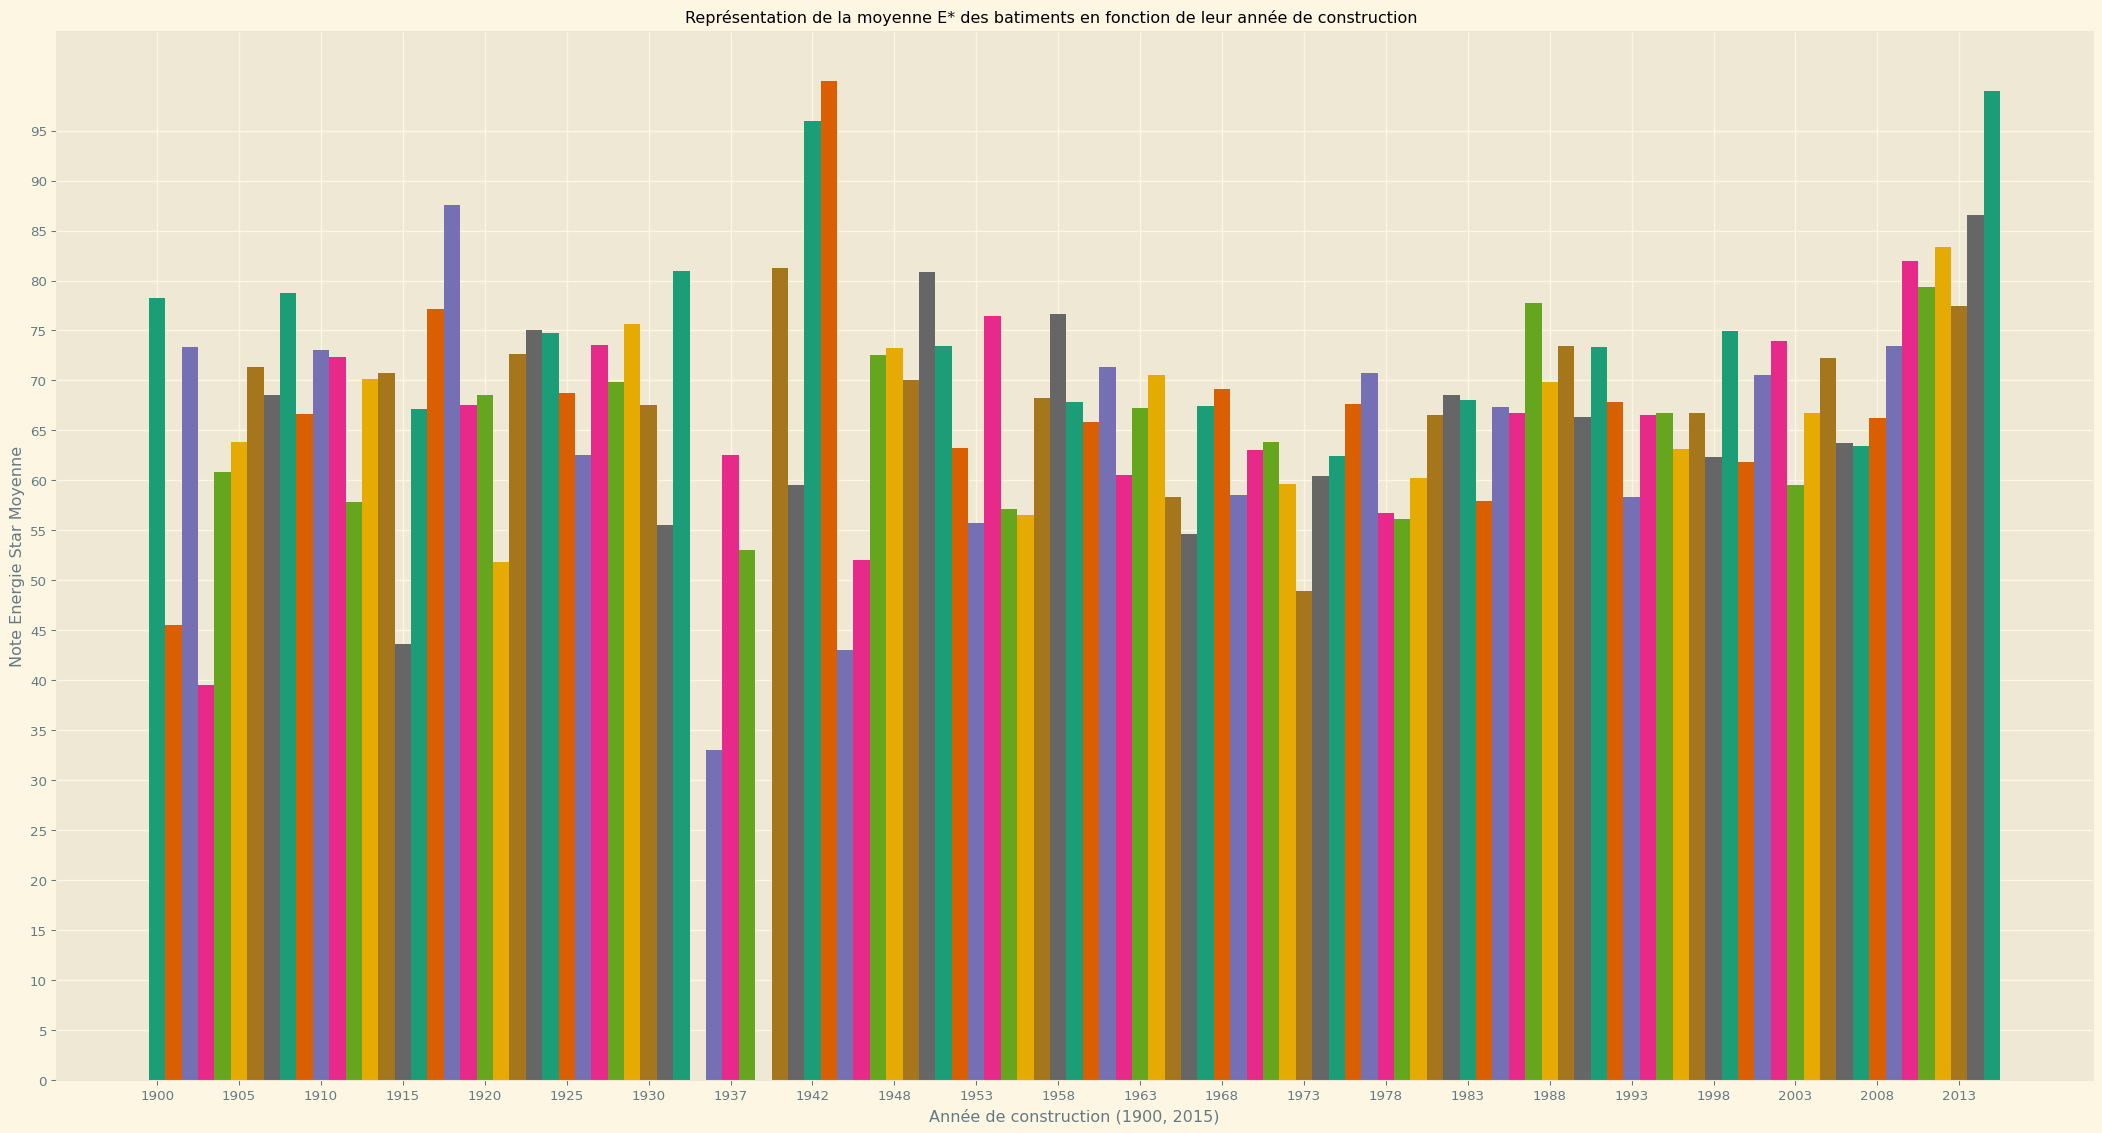

In [115]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

years_list = list(df_sixteen[df_sixteen["YearBuilt"].notna()]["YearBuilt"].values)
year_keys = []
for year in years_list:
    if year not in year_keys:
        year_keys.append(year)

year_keys.sort()

year_dict = dict.fromkeys(year_keys)

for key in year_dict.keys():
    temp = df_sixteen[(df_sixteen["YearBuilt"] == key) & (df_sixteen["ENERGYSTARScore"].notna())]
    scores = [int(i) for i in temp["ENERGYSTARScore"]]
    try:
        mean = sum(scores) / len(scores)
        year_dict[key] = mean
    except ZeroDivisionError:
        year_dict[key] = 0

ax1.bar(
    x=list(year_dict.keys()),
    height=list(year_dict.values()),
    color=used_cmap.colors,
    width=1,
    )

###
# Titles/Lables
ax1.set_xticks(np.arange(0, len(list(year_dict.keys())), 5))
ax1.set_yticks(np.arange(0, 100, 5))
ax1.set_ylabel("Note Energie Star Moyenne")
ax1.set_xlabel("Année de construction (1900, 2015)")
fig.suptitle("Représentation de la moyenne E* des batiments en fonction de leur année de construction")
#
###

fig.tight_layout()
plt.show()


### Observation :
- L'année de construction ne semble pas avoir d'influence sur la note E* - Cela peut venir, comme ecrit plus haut, de travaux de modernisation par exemple.

## 4 : Note E* en fonction du type de batiment étudié

In [116]:
print(2015)

uniques = df_fifteen["PrimaryPropertyType"].unique()
unique_property_fifteen_type_dict = dict.fromkeys(uniques)
for unique in unique_property_fifteen_type_dict.keys():
    unique_property_fifteen_type_dict[unique] = len(df_fifteen[df_fifteen["PrimaryPropertyType"] == unique])

unique_property_fifteen_type_dict


2015


{'Hotel': 73,
 'Other': 251,
 'Mid-Rise Multifamily': 535,
 'Mixed Use Property': 125,
 'K-12 School': 134,
 'College/University': 22,
 'Small- and Mid-Sized Office': 290,
 'Self-Storage Facility\n': 27,
 'Distribution Center': 2,
 'Large Office': 168,
 'Retail Store': 97,
 'Senior Care Community': 43,
 'Medical Office': 40,
 'Hospital': 10,
 'Residence Hall/Dormitory': 15,
 'Non-Refrigerated Warehouse': 185,
 'Distribution Center\n': 51,
 'SPS-District K-12': 4,
 'Worship Facility': 71,
 'Low-Rise Multifamily': 976,
 'Supermarket/Grocery Store': 36,
 'Laboratory': 1,
 'Self-Storage Facility': 1,
 'Refrigerated Warehouse': 13,
 'High-Rise Multifamily': 103,
 'Restaurant\n': 10,
 'Restaurant': 1}

In [117]:
uniques = df_fifteen["BuildingType"].unique()
unique_fifteen_btype_dict = dict.fromkeys(uniques)
for unique in unique_fifteen_btype_dict.keys():
    unique_fifteen_btype_dict[unique] = len(df_fifteen[df_fifteen["BuildingType"] == unique])

unique_fifteen_btype_dict


{'NonResidential': 1433,
 'Nonresidential COS': 68,
 'Multifamily MR (5-9)': 550,
 'SPS-District K-12': 98,
 'Campus': 21,
 'Multifamily LR (1-4)': 1007,
 'Multifamily HR (10+)': 107}

In [118]:
print(2016)

uniques = df_sixteen["PrimaryPropertyType"].unique()
unique_property_sixteen_type_dict = dict.fromkeys(uniques)
for unique in unique_property_sixteen_type_dict.keys():
    unique_property_sixteen_type_dict[unique] = len(df_sixteen[df_sixteen["PrimaryPropertyType"] == unique])

unique_property_sixteen_type_dict


2016


{'Hotel': 74,
 'Other': 243,
 'Mid-Rise Multifamily': 535,
 'Mixed Use Property': 127,
 'K-12 School': 138,
 'University': 21,
 'Small- and Mid-Sized Office': 291,
 'Self-Storage Facility': 28,
 'Warehouse': 184,
 'Large Office': 167,
 'Senior Care Community': 44,
 'Medical Office': 39,
 'Retail Store': 91,
 'Hospital': 10,
 'Residence Hall': 15,
 'Distribution Center': 53,
 'Worship Facility': 71,
 'Low-Rise Multifamily': 977,
 'Supermarket / Grocery Store': 40,
 'Laboratory': 10,
 'Refrigerated Warehouse': 12,
 'Restaurant': 12,
 'High-Rise Multifamily': 102}

In [119]:
uniques = df_sixteen["BuildingType"].unique()
unique_property_fivteen_btype_dict = dict.fromkeys(uniques)
for unique in unique_property_fivteen_btype_dict.keys():
    unique_property_fivteen_btype_dict[unique] = len(df_sixteen[df_sixteen["BuildingType"] == unique])

unique_property_fivteen_btype_dict

{'NonResidential': 1434,
 'Nonresidential COS': 67,
 'Multifamily MR (5-9)': 549,
 'SPS-District K-12': 98,
 'Campus': 22,
 'Multifamily LR (1-4)': 1007,
 'Multifamily HR (10+)': 107}

## Objectifs :

- Mettre en évidence une différence suffisamment significative pour considerer les batiments en tant que differentes classes
- Démontrer l'interêt d'une classification issue du ML (k-means par exemple)
- Accélerer la classification des batiments en se basant, si possible, partiellement sur le type de batiment

## Pre-traitement : 
- Correction des typos, chariage returns, tabulations, double espaces etc.
- Groupement manuel de types similaires manuellement, non évident pour une machine (i.e. : Lab & Senior Facility in medical)
- Elimination des types rares (--> others)

In [120]:
for key in unique_property_fifteen_type_dict.keys():
    if key not in unique_property_sixteen_type_dict.keys():
        unique_property_sixteen_type_dict[key] = "Primary Type Changed"
    elif key in unique_property_sixteen_type_dict.keys():
        pass

unique_common_ptype = unique_property_sixteen_type_dict
unique_common_ptype


{'Hotel': 74,
 'Other': 243,
 'Mid-Rise Multifamily': 535,
 'Mixed Use Property': 127,
 'K-12 School': 138,
 'University': 21,
 'Small- and Mid-Sized Office': 291,
 'Self-Storage Facility': 28,
 'Warehouse': 184,
 'Large Office': 167,
 'Senior Care Community': 44,
 'Medical Office': 39,
 'Retail Store': 91,
 'Hospital': 10,
 'Residence Hall': 15,
 'Distribution Center': 53,
 'Worship Facility': 71,
 'Low-Rise Multifamily': 977,
 'Supermarket / Grocery Store': 40,
 'Laboratory': 10,
 'Refrigerated Warehouse': 12,
 'Restaurant': 12,
 'High-Rise Multifamily': 102,
 'College/University': 'Primary Type Changed',
 'Self-Storage Facility\n': 'Primary Type Changed',
 'Residence Hall/Dormitory': 'Primary Type Changed',
 'Non-Refrigerated Warehouse': 'Primary Type Changed',
 'Distribution Center\n': 'Primary Type Changed',
 'SPS-District K-12': 'Primary Type Changed',
 'Supermarket/Grocery Store': 'Primary Type Changed',
 'Restaurant\n': 'Primary Type Changed'}

## Observations :
- SPS -> Seattle Public School
- K12 -> Shool -> from kindergarten to 12th grade
- Typos, doubles espaces etc.
- Pré groupement via généralisation

In [121]:
correction_dict = {
    "Self-Storage Facility\n": "Self-Storage Facility",  # Possibly warehouse
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Restaurant\n": "Restaurant",
    "Distribution Center\n": "Supermarket & Grocery store",
    "Distribution Center": "Supermarket & Grocery store",
    "Supermarket/Grocery Store": "Supermarket & Grocery store",
    "Supermarket / Grocery Store": "Supermarket & Grocery store",
    "SPS-District K-12": "K-12 School",
    "Senior Care Community": "Small & Medium medical facility",  # Unsure
    "Laboratory": "Small & Medium medical facility",  # Unsure
    "Medical Office": "Small & Medium medical facility",  # Unsure
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Non-Refrigerated Warehouse": "Warehouse",
    "Residence Hall/Dormitory": "Residence Hall",
    "University": "College/University",
    "Retail Store": "Supermarket & Grocery store",
    "Self-Storage Facility": "Warehouse",  # Unsure
}

len(correction_dict.keys())


16

In [122]:
for key in correction_dict.keys():
    df_fifteen["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)
    df_sixteen["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)

In [123]:
df_sixteen["PrimaryPropertyType"].value_counts()

Low-Rise Multifamily               977
Mid-Rise Multifamily               535
Small & Mid-Sized Office           291
Other                              243
Warehouse                          212
Supermarket & Grocery store        184
Large Office                       167
K-12 School                        138
Mixed Use Property                 127
High-Rise Multifamily              102
Small & Medium medical facility     93
Hotel                               74
Worship Facility                    71
College/University                  21
Residence Hall                      15
Refrigerated Warehouse              12
Restaurant                          12
Hospital                            10
Name: PrimaryPropertyType, dtype: int64

In [124]:
select_eight = [
    "Mid-Rise Multifamily", "Small & Mid-Sized Office", "Warehouse", "Supermarket & Grocery store",
    "K-12 School", "Large Office", "High-Rise Multifamily", "Small & Medium medical facility",
]


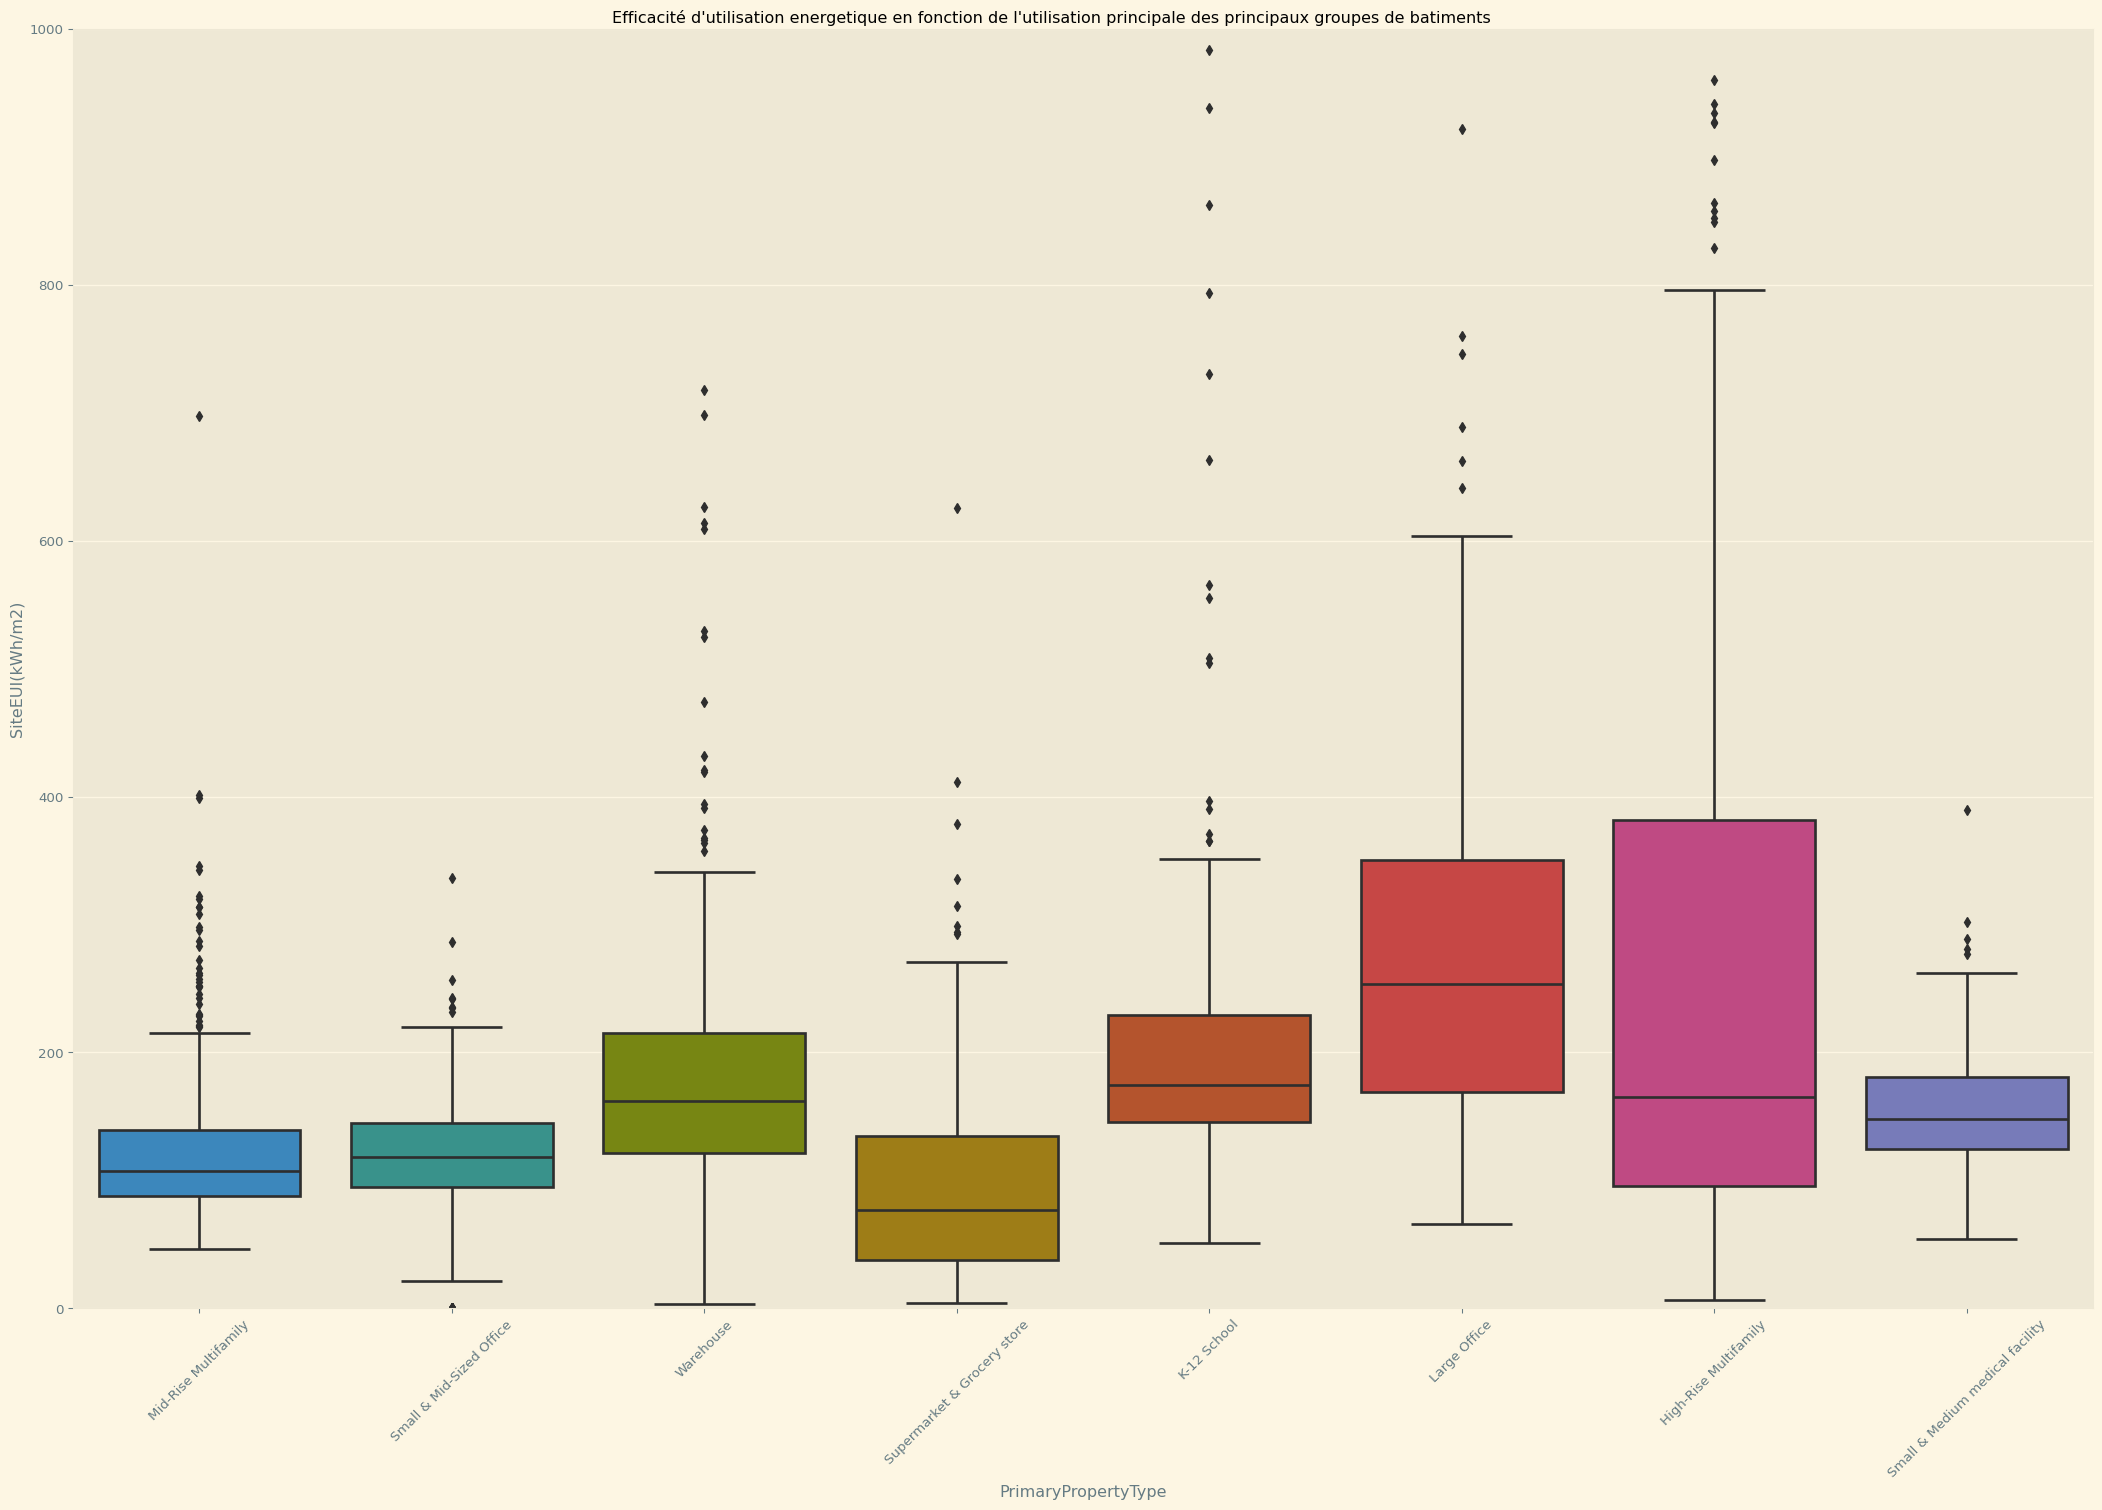

In [125]:
# EUI / E* , color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_sixteen[df_sixteen["PrimaryPropertyType"].isin(select_eight)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["SiteEUI(kWh/m2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_eight,
    rotation=45
    )
ax1.set_ylim(0, 1000)  # few outliers above
fig.suptitle("Efficacité d'utilisation energetique en fonction de l'utilisation principale des principaux groupes de batiments")

#
###

plt.tight_layout()
plt.show()

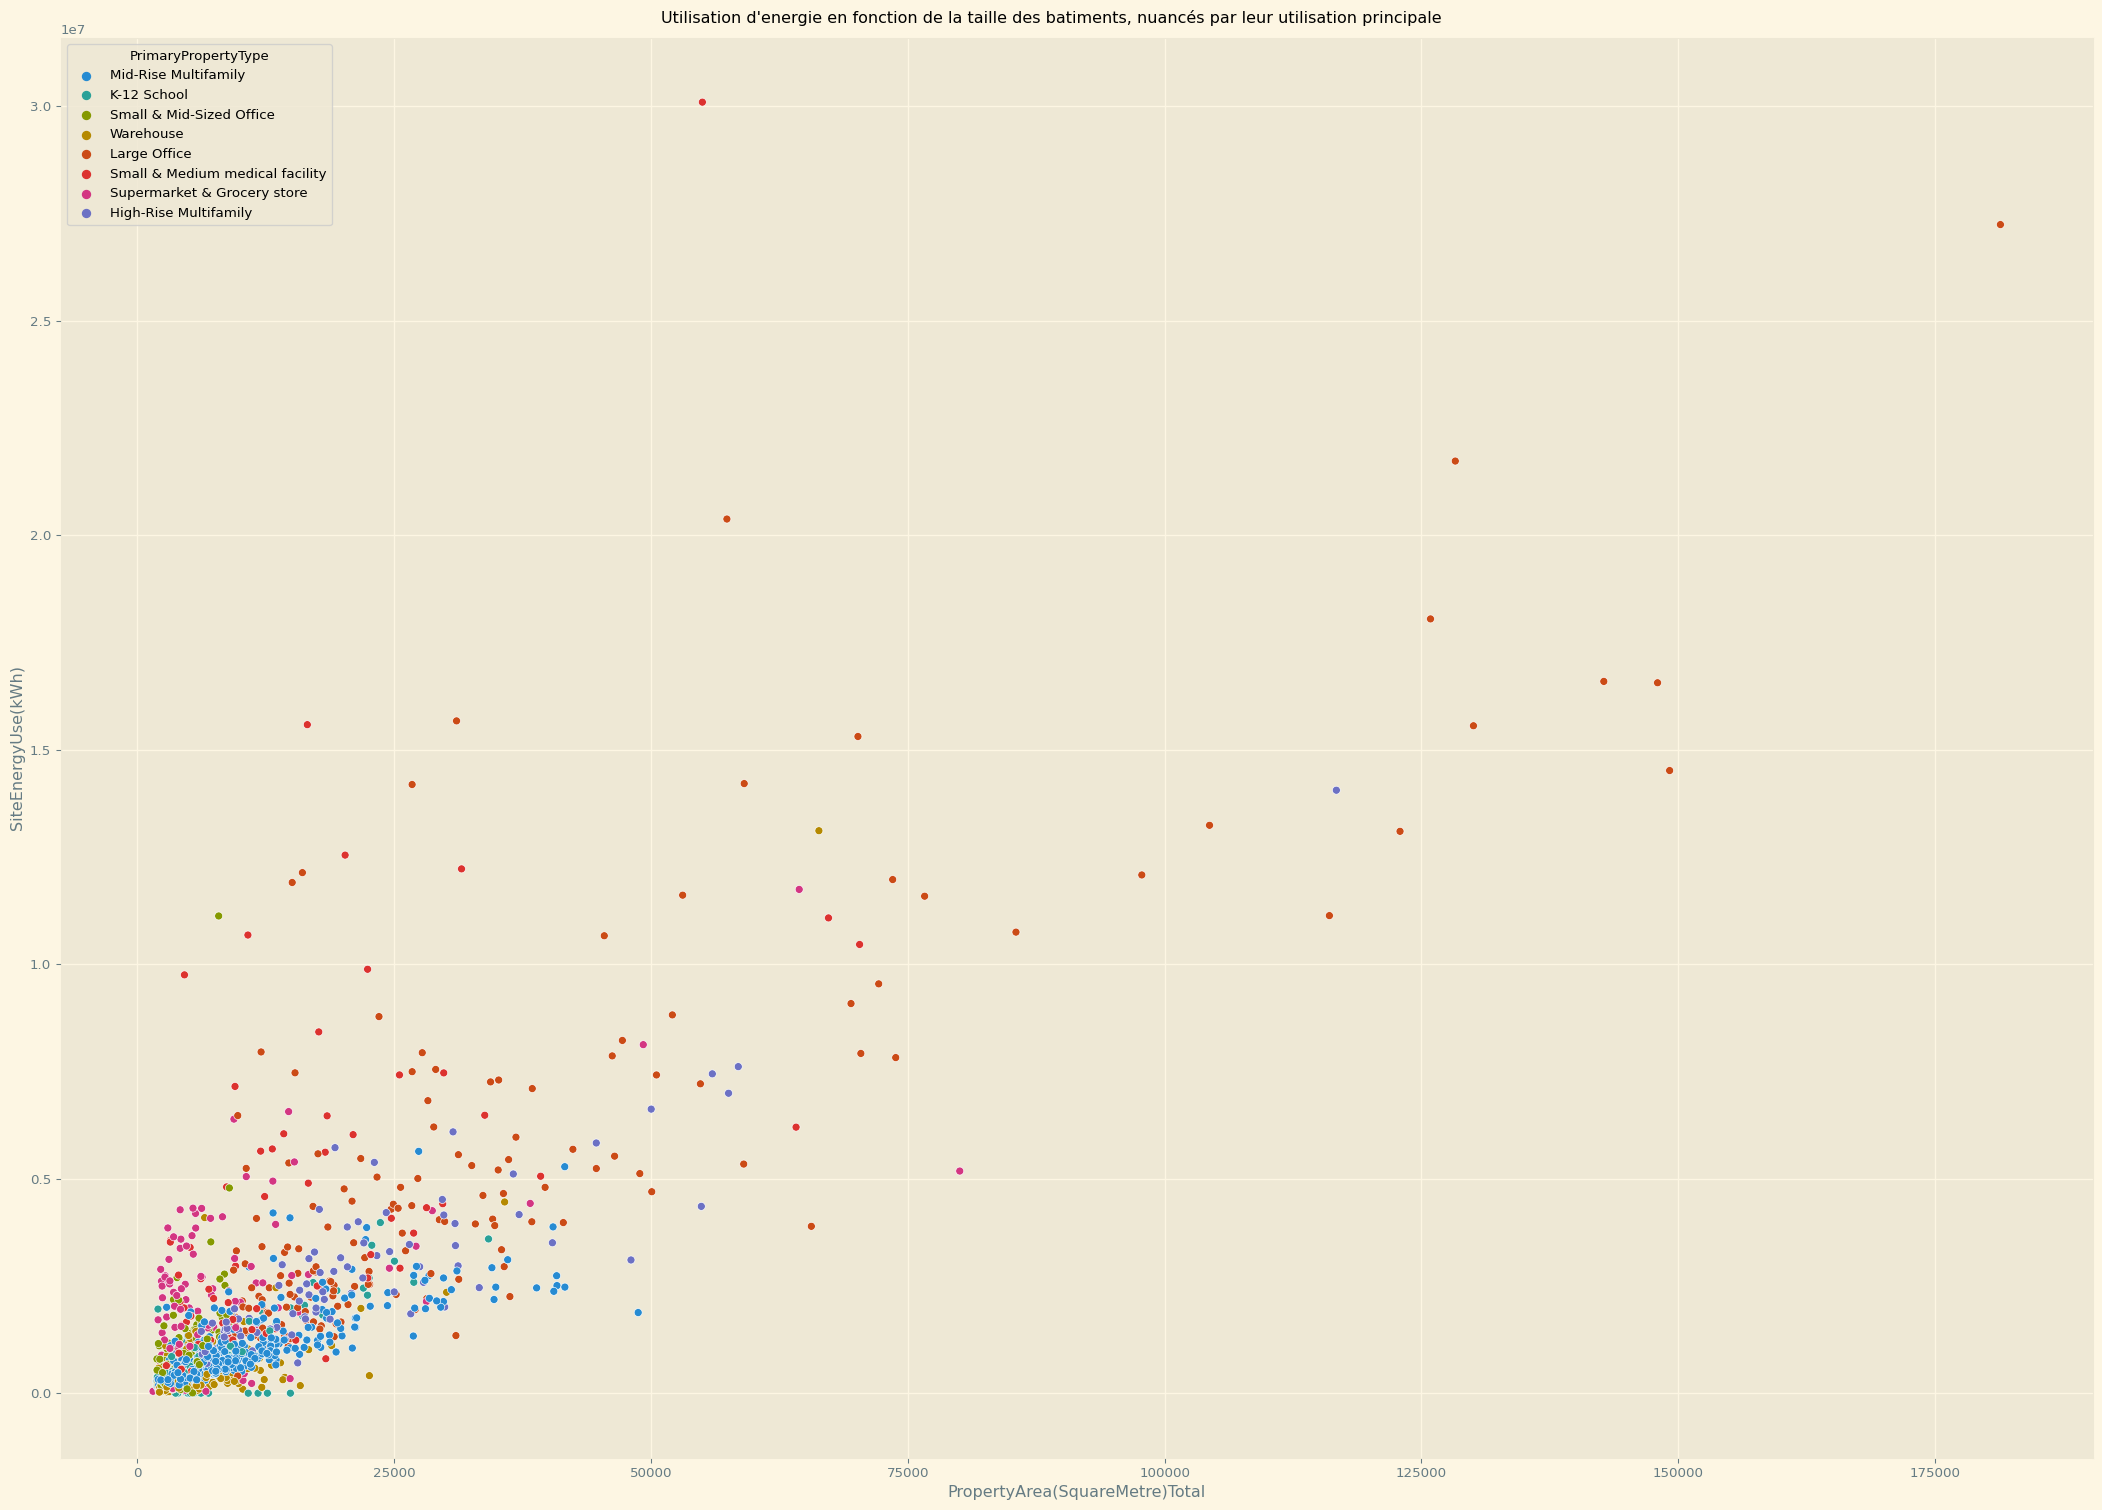

In [126]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

ax1 = sns.scatterplot(
    x="PropertyArea(SquareMetre)Total",
    y="SiteEnergyUse(kWh)",
    hue="PrimaryPropertyType",
    data=data_ptype
)

###
# Titles/Lables
fig.suptitle("Utilisation d'energie en fonction de la taille des batiments, nuancés par leur utilisation principale")
#
###

plt.tight_layout()
plt.show()


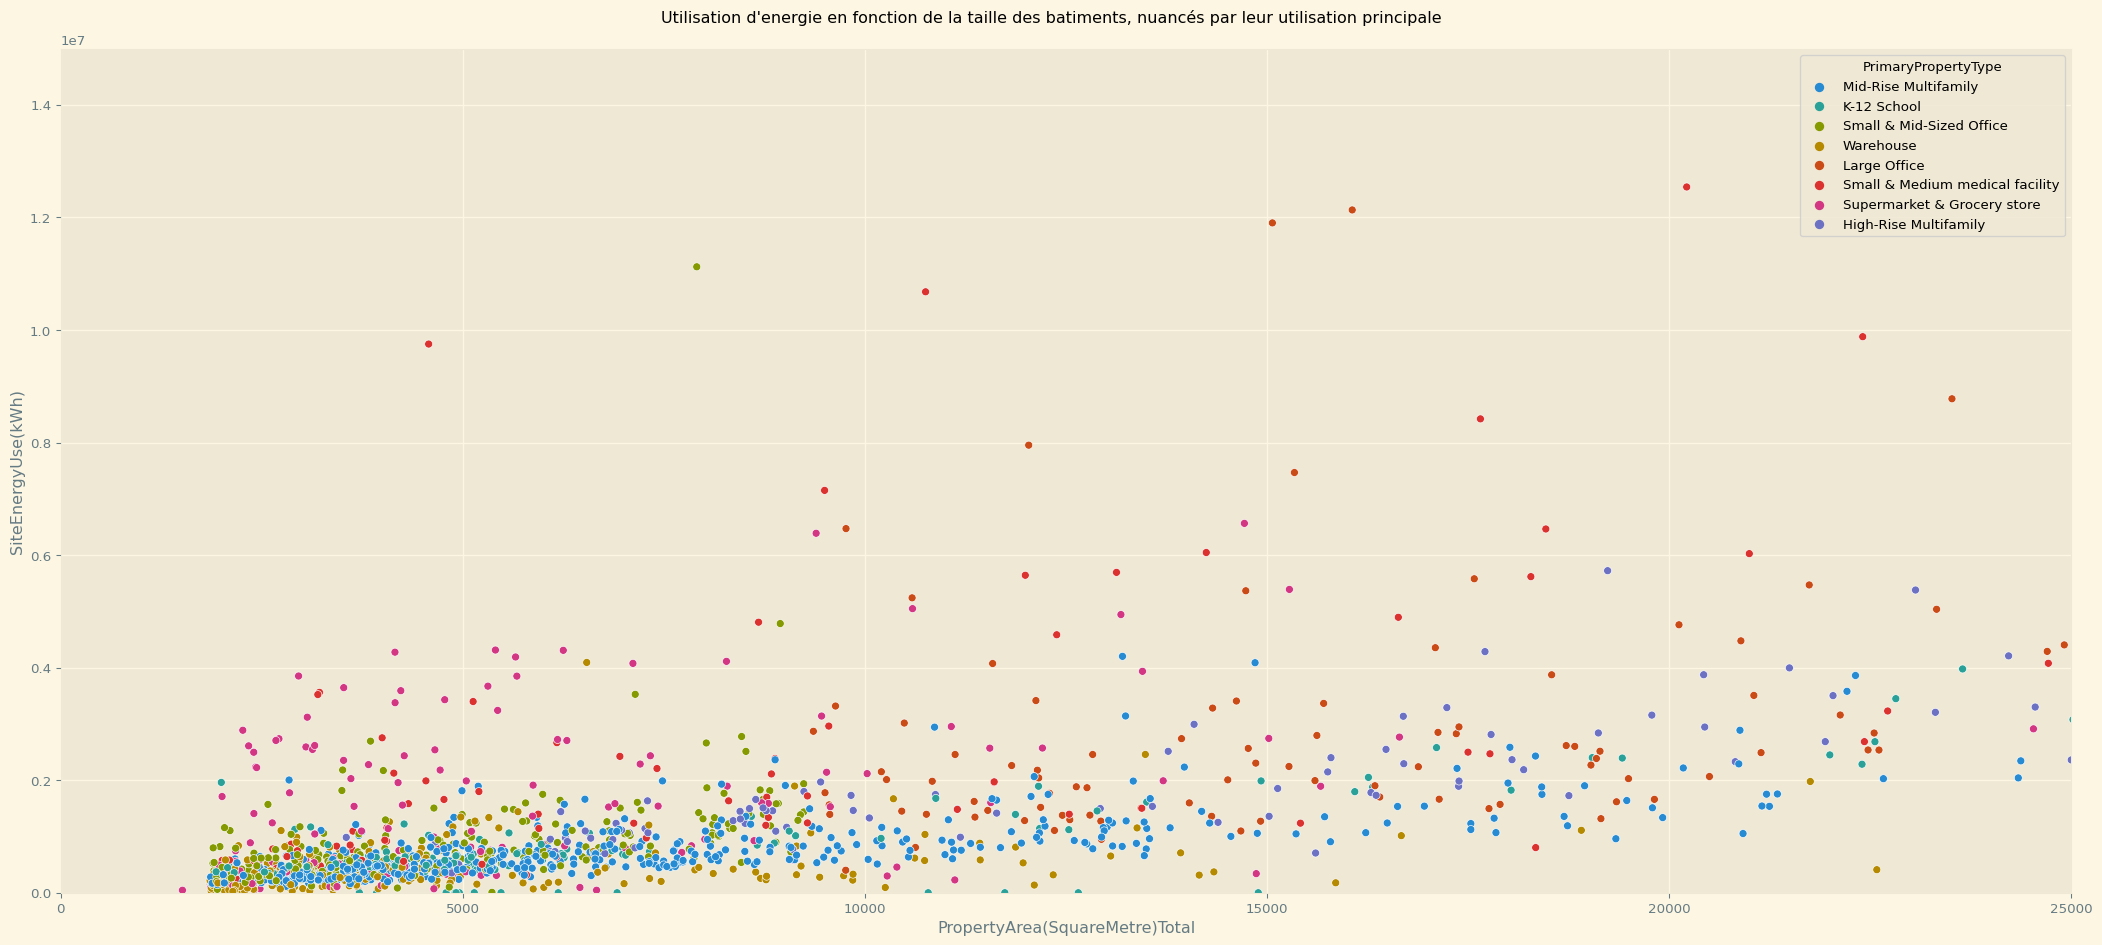

In [127]:
# Zooming on y=0.5 kWh/m2, x= 25km2

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.scatterplot(
    x="PropertyArea(SquareMetre)Total",
    y="SiteEnergyUse(kWh)",
    hue="PrimaryPropertyType",
    data=data_ptype
)


ax1.set_ylim(-100, 15000000)
ax1.set_xlim(0, 25000)

###
# Titles/Lables
fig.suptitle("Utilisation d'energie en fonction de la taille des batiments, nuancés par leur utilisation principale")
#
###

plt.tight_layout()
plt.show()


## Observation : On peut effectuer quelques remarques, malgré une apparence très groupée

- On distingue relativement facilement un groupe : Supermarket & Grocery Store (@ 2000-4000 MWh & 2.5-8 km2)
- Les batiments d'habitations (High rises et Mid Rises) semble obeir à une corrélation linéaire entre Zone totale et Utilisation d'Energie
- Medical Offices affiche une forte variance, sans doute causée par la présence, ou absence, d'équipement medical à forte utilisation d'energie (équipement variant majoritairement du fait de la spécialisation)
- Le boxplot montre que, si des batiments remplissent la meme fonction (dans le diagramme : high rise / mid rise = habitation, small/medium offices et large offices = Bureaux), l'efficacité d'utilisation energétique semble fortement augmenter avec la taille (denomination) du batiment, utilisation du Student's T-Test pour observer une correllation entre les deux paires étudiés
- On peut tenter d'effectuer un test ANOVA ou CHI2 pour identifier les corrélations si elles existent.


## Realisation de T-Tests (A) pour vérifier si l'augmentation de l'EUI est corrélée avec l'augmentation de la taille des batiments, ici : 
- Categories et hypothèses nulles :
    - High Rise vs Mid Rise : L'augmentation de l'EUI n'a rien à voir avec la difference de taille des batiments d'habitation
    - Small & Medium Office vs Large Office : L'augmentation de l'EUI n'a rien à voir avec la difference de taille d'immeubles de bureaux
- Les deux échantillons doivent être indépendants (ce qui est le cas)
- La variance inter echantillon doit être homogène (utilisation du test de Bartlett)
- Les résidus doivent suivre une distribution normale (ce qui sera vérifié en utilisant le test de Shapiro Wilks)
- On fixe alpha à 5%
- On cherche à rejeter les hypothèses nulles


In [128]:
alpha = 0.05

In [129]:
# High Rise / Mid Rise

high_rise_eui = df_sixteen[df_sixteen["PrimaryPropertyType"] == "High-Rise Multifamily"]["SiteEUI(kWh/m2)"]
mid_rise_eui = df_sixteen[df_sixteen["PrimaryPropertyType"] == "Mid-Rise Multifamily"]["SiteEUI(kWh/m2)"]

ttest_hab = stats.ttest_ind(a=high_rise_eui, b=mid_rise_eui)

print(ttest_hab, "\n", f"p-values < alpha : {ttest_hab.pvalue < alpha}")


Ttest_indResult(statistic=5.438906665461575, pvalue=7.658066896468118e-08) 
 p-values < alpha : True


In [130]:
# Null hypothesis : homoscedasticity

bartlett_test_hab = stats.bartlett(high_rise_eui, mid_rise_eui)

print(bartlett_test_hab, "\n", f"p-values > alpha : {bartlett_test_hab.pvalue > alpha}")


BartlettResult(statistic=1.7844973977008804, pvalue=0.1815980402655537) 
 p-values > alpha : True


### Analyse du t-test A.1 --> Batiments d'habitation : 
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène, on accepte l'hypothèse nulle : les variances des echantillons sont homogènes
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = L'augmentation de l'EUI n'a rien à voir avec la difference de taille des batiments d'habitation, on accepte l'hypothèse alternative H1, à savoir : Dans le cas des immeubles d'habitations, l'augmentation de la taille cause une hausse de l'EUI (kWh/m2).
  

In [131]:
# Large Office / Small & Mid-Sized Office

large_office_eui = df_sixteen[(df_sixteen["PrimaryPropertyType"] == "Large Office") & (df_sixteen["SiteEUI(kWh/m2)"].notna())]["SiteEUI(kWh/m2)"]
small_m_office_eui = df_sixteen[(df_sixteen["PrimaryPropertyType"] == "Small & Mid-Sized Office") & (df_sixteen["SiteEUI(kWh/m2)"].notna())]["SiteEUI(kWh/m2)"]

ttest_office = stats.ttest_ind(a=small_m_office_eui, b=large_office_eui, equal_var=False)

print(ttest_office, "\n", f"p-values < alpha : {ttest_office.pvalue < alpha}")

Ttest_indResult(statistic=-2.282998778339716, pvalue=0.023106836069765366) 
 p-values < alpha : True


In [132]:
# Null hypothesis : homoscedasticity

bartlett_test_office = stats.bartlett(large_office_eui, small_m_office_eui)

print(bartlett_test_office, "\n", f"p-values > alpha : {bartlett_test_office.pvalue > alpha}")

BartlettResult(statistic=3.8091618478079248, pvalue=0.050972951330887875) 
 p-values > alpha : True


### Analyse du t-test A.2 --> Immeubles de bureau :
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène, on accepte l'hypothèse nulle : les variances des echantillons sont homogènes
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = L'augmentation de l'EUI n'a rien à voir avec la difference de taille des immeubles de bureau, on accepte l'hypothèse alternative H1, à savoir : Dans le cas des bureaux, l'augmentation de la taille cause une hausse de l'EUI (kWh/m2).


## Analyse :

- Ces deux tests confirment que l'éfficacité énergétique se déteriore, pour les batiments de meme type mais de tailles differentes
- Un modèle prenant en compte cette conclusion pourrait profiter d'une accélleration de performance dans la prediction de l'éfficacité energetique d'un batiment
- Une première analyse effectuee plus haut ne permettait pas de corréler la note E* à la taille des batiments. Il peut etre interessant de voir si le type de batiment n'a egalement pas, visiblement, d'influence sur la note E* :
  - Si corrélation : Meilleure comprehension de la note.
  - Sinon : Note basée sur d'autres facteurs / comprehensive de l'observation ci dessus.

In [133]:
hab_off = ["Mid-Rise Multifamily", "High-Rise Multifamily", "Small & Mid-Sized Office", "Large Office"]


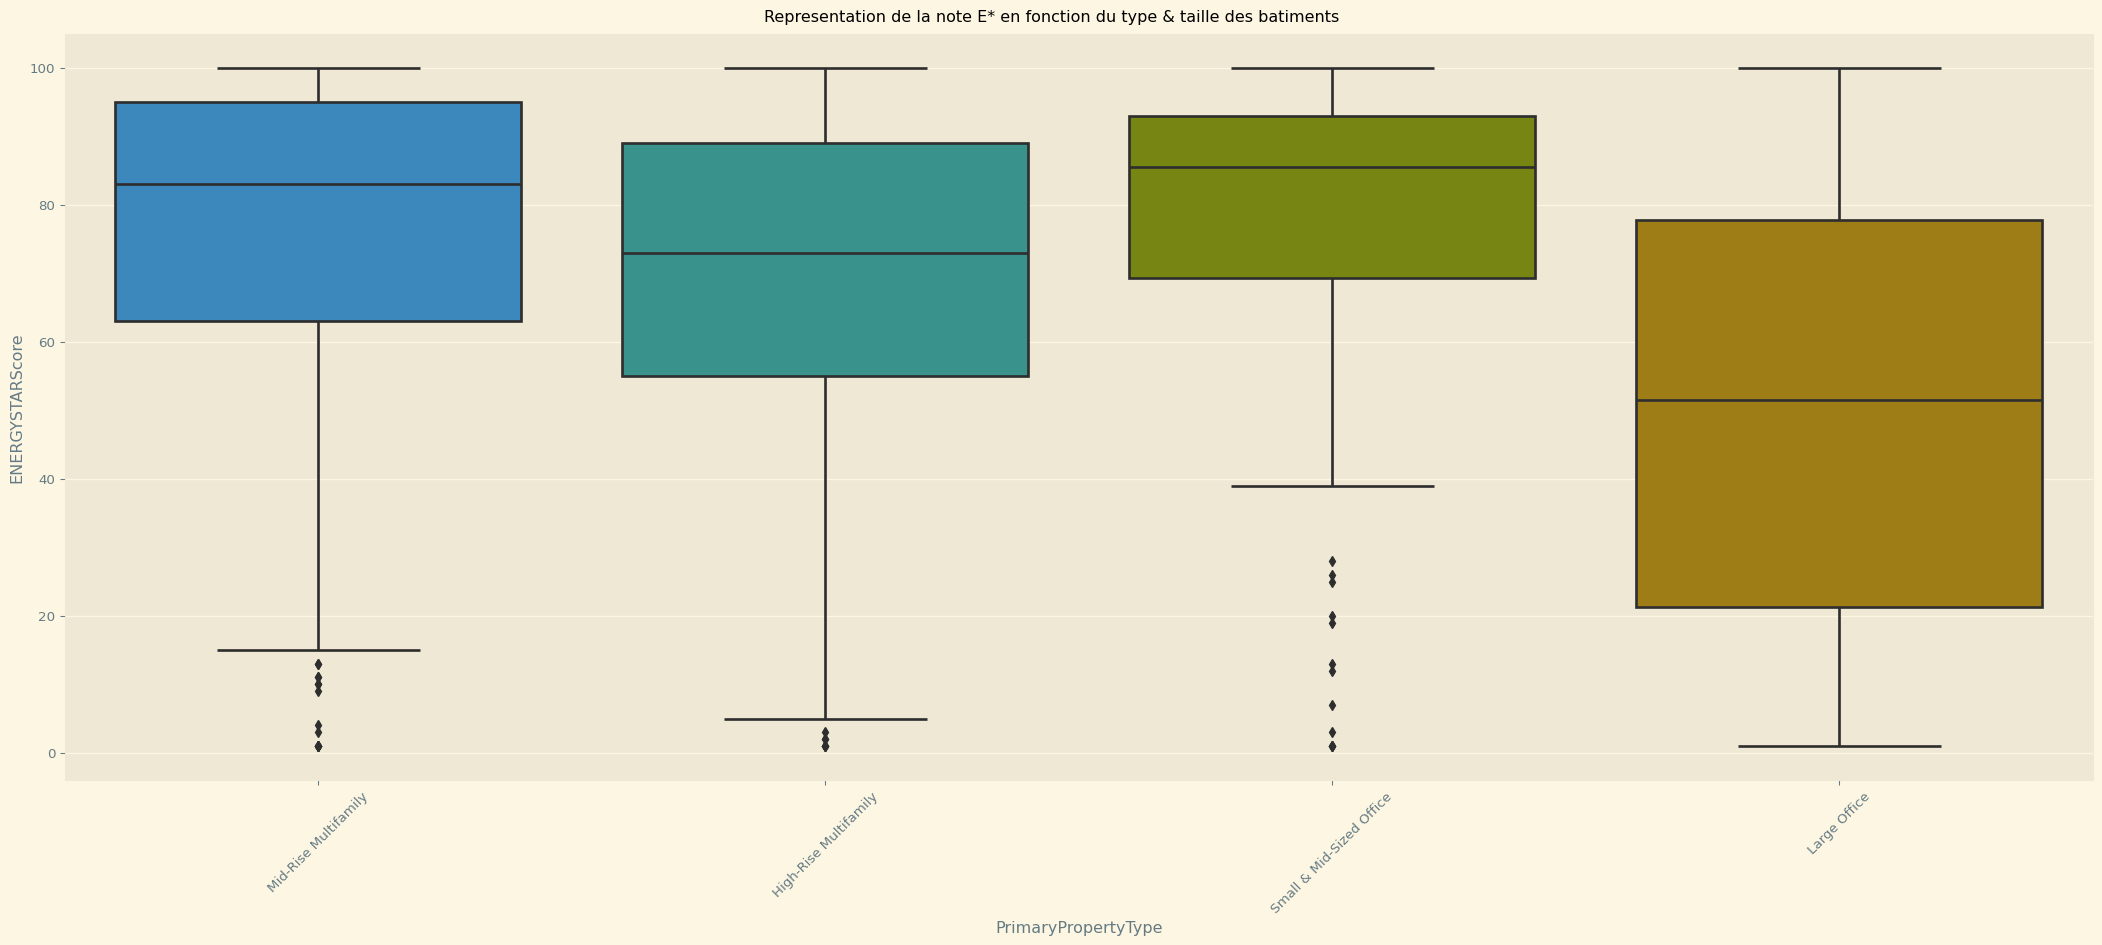

In [134]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

data_es_ptype = df_sixteen[
    (df_sixteen["PrimaryPropertyType"].isin(hab_off)) &
    (df_sixteen["ENERGYSTARScore"].notna()) &
    (df_sixteen["SiteEUI(kWh/m2)"].notna())
    ]

ax1 = sns.boxplot(
        x=data_es_ptype["PrimaryPropertyType"],
        y=data_es_ptype["ENERGYSTARScore"].astype(int),
        data=data_es_ptype
    )


###
# Titles/Lables
ax1.set_xticklabels(
    labels=hab_off,
    rotation=45
    )
fig.suptitle("Representation de la note E* en fonction du type & taille des batiments")
#
###

fig.tight_layout()
plt.show()

## Observations :
- La meme tendance observee dans l'analyse de l'EUI par type de batiment semble etre egalement presente dans ce cas
- La variance semble similaire dans le cas des batiments d'habitation, le cas des immeubles du bureau montre une variance largement superieure dans le cas des plus grands batiments
- On peut effectuer les memes series de tests que dans le cas de l'EUI, meme si le critere d'homoscédasticité semble invalide dans le cas des bureaux

## Realisation de T-Tests pour vérifier si la baisse de la note E* est corrélée avec l'augmentation de la taille des batiments, ici : 
- Categories et hypothèses nulles :
    - High Rise vs Mid Rise : Le baisse globale des notes n'est pas corrélée avec la taille des batiments d'habitation. 
    - Small & Medium Office vs Large Office : Le baisse globale des notes n'est pas corrélée avec la taille des bureaux. 
- Les deux échantillons doivent être indépendants (ce qui est le cas)
- La variance inter echantillon doit être homogène (utilisation du test de Bartlett)
- Les résidus doivent suivre une distribution normale (ce qui sera vérifié en utilisant le test de Shapiro Wilks)
- On fixe alpha à 5%
- On cherche à rejeter les hypothèses nulles


In [135]:
# High Rise / Mid Rise

high_rise_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "High-Rise Multifamily") &
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)

mid_rise_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Mid-Rise Multifamily") & 
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)

In [136]:
# Null hypothesis : homoscedasticity

bartlett_test_estar_hab = stats.bartlett(high_rise_estar, mid_rise_estar)

print(bartlett_test_estar_hab, "\n", f"p-values > alpha : {bartlett_test_estar_hab.pvalue > alpha}")


BartlettResult(statistic=6.37793351824855, pvalue=0.011554789107619196) 
 p-values > alpha : False


In [137]:
# Std not equal with alpha @5%, using ttest ind with parameter : equal_var = False

ttest_estar_hab = stats.ttest_ind(a=high_rise_estar, b=mid_rise_estar, equal_var=False)

print(ttest_estar_hab, "\n", f"p-values < alpha : {ttest_estar_hab.pvalue < alpha}")


Ttest_indResult(statistic=-7.45746084569825, pvalue=1.7972886903204765e-11) 
 p-values < alpha : True


### Analyse du t-test B.1 --> Batiments d'habitation : 
- Le test de Bartlett permet d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène. Les parametres du t-test sont ajustés pour refleter cela : equal_var = False
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = Le baisse globale des notes n'est pas corrélée avec la taille des batiments d'habitation. On accepte l'hypothèse alternative H1, à savoir : Il existe une corrélation négative entre la taille d'un batiment d'habitation et sa note E*

In [138]:
# Large Office / Small & Mid-Sized Office

large_off_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Large Office") &
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)

small_med_off_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Small & Mid-Sized Office") & 
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)


In [139]:
# Null hypothesis : homoscedasticity

bartlett_test_estar_off = stats.bartlett(large_off_estar, small_med_off_estar)

print(bartlett_test_estar_off, "\n", f"p-values > alpha : {bartlett_test_estar_off.pvalue > alpha}")


BartlettResult(statistic=1.5054359149435483, pvalue=0.21983684833444364) 
 p-values > alpha : True


In [140]:
# Std equal with alpha @5%, using ttest ind with parameter : equal_var = True

ttest_estar_off = stats.ttest_ind(a=large_off_estar, b=small_med_off_estar, equal_var=True)

print(ttest_estar_off, "\n", f"p-values < alpha : {ttest_estar_off.pvalue < alpha}")

Ttest_indResult(statistic=3.3459869164565816, pvalue=0.000898647390218984) 
 p-values < alpha : True


### Analyse du t-test B.2 --> Batiments d'habitation : 
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène. On accepte l'hypothèse alternative : Les variances sont homogènes.
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = Le baisse globale des notes n'est pas corrélée avec la taille des bureaux. On accepte l'hypothèse alternative H1, à savoir : Il existe une corrélation négative entre la taille d'un immeuble de bureau et sa note E*

## Conclusions A & B : :Valable seulement dans les categories des bureaux et des habitations:
- On peut constater, dans le cas des batiments d'habitation et des bureaux, une corréllation, a la fois positive vis à vis de l'EUI (+ = moins efficace) & négative dans le cas de la note E*
- La note E* n'est pas comprehensive de la taille d'un batiment
- On peut conclure que la note E* est bien plus influencée par l'efficacité energétique d'un batiment que par sa taille. Plus un batiment est grand, plus on peut s'attendre a une augmentation de la consommation electrique horaire par metre carré, et donc une influence négative sur sa note E*